In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import gc
import numpy as np


# Base functions

## Data loaders

In [2]:
class DataLoaderWrapCIFAR10:
    def __init__(self, batch = 64):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        self.train_data = datasets.CIFAR10(
            root="./data",
            train=True,
            transform=transform,
            download=True
        )

        self.test_data = datasets.CIFAR10(
            root="./data",
            train=False,
            transform=transform,
            download=True
        )

        self.train_loader = DataLoader(
            self.train_data,
            batch_size=batch,
            shuffle=True
            )

        self.test_loader = DataLoader(
            self.test_data,
            batch_size=batch,
            shuffle=False
            )

        self.class_names = self.train_data.classes


In [3]:
class DataLoaderWrapMNIST:
    def __init__(self, batch = 64):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        self.train_data = datasets.MNIST(
            root="./data",
            train=True,
            transform=transform,
            download=True
        )

        self.test_data = datasets.MNIST(
            root="./data",
            train=False,
            transform=transform,
            download=True
        )

        self.train_loader = DataLoader(
            self.train_data,
            batch_size=batch,
            shuffle=True
            )

        self.test_loader = DataLoader(
            self.test_data,
            batch_size=batch,
            shuffle=False
            )

        self.class_names = self.train_data.classes

In [4]:
class DataLoaderWrapEMNIST:
    def __init__(self, batch = 64):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        self.train_data = datasets.EMNIST(
            root="./data",
            split = 'letters',
            train=True,
            transform=transform,
            download=True
        )

        self.test_data = datasets.EMNIST(
            root="./data",
            split = 'letters',
            train=False,
            transform=transform,
            download=True
        )

        self.train_loader = DataLoader(
            self.train_data,
            batch_size=batch,
            shuffle=True
            )

        self.test_loader = DataLoader(
            self.test_data,
            batch_size=batch,
            shuffle=False
            )

        self.class_names = self.train_data.classes

## Trainer

In [5]:
class ModelUtils:
    def __init__(self, model, learning_rate=0.001):
        self.model = model

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )

        self.model.to(self.device)

        # to use softmax in the model, you do not need to use nn.CrossEntropyLoss()
        # self.criterion = nn.CrossEntropyLoss()
        # nn.CrossEntropyLoss() = nn.functional.log_softmax(self.fc3(x), dim=1) + nn.NLLLoss()
        self.criterion = nn.NLLLoss()
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=learning_rate
        )

    def train(self, train_loader, test_loader, epochs):
        self.model.train()
        self.training_losses = []
        self.validation_losses = []
        training_outputs = []
        validation_outputs = []

        for epoch in range(epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:

                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                self.optimizer.zero_grad()

                training_outputs = self.model(inputs)

                loss = self.criterion(training_outputs[0], labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

            avg_training_loss = running_loss / len(train_loader)
            self.training_losses.append(avg_training_loss)

            val_loss = 0.0

            self.model.eval()
            with torch.no_grad():
                for val_inputs, val_labels in test_loader:
                    val_inputs, val_labels = val_inputs.to(self.device), val_labels.to(self.device)
                    validation_outputs = self.model(val_inputs)
                    val_loss += self.criterion(validation_outputs[0], val_labels).item()

            avg_validation_loss = val_loss / len(test_loader)
            self.validation_losses.append(avg_validation_loss)
            self.model.train()

            print(f"Epoch {epoch + 1}, Training Loss: {avg_training_loss}, Validation Loss: {avg_validation_loss}")

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for inputs, labels in test_loader:

                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)

                _, predicted = torch.max(outputs[0].data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        print(f"Accuracy: {accuracy}%")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")

        plt.plot(range(1, len(self.training_losses) + 1), self.training_losses, label='Training Loss', marker='o')
        plt.plot(range(1, len(self.validation_losses) + 1), self.validation_losses, label='Validation Loss', marker='x')
        plt.title("Training and Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def predict(self, image):
        self.model.eval()
        image = image.to(self.device)
        with torch.no_grad():
            output = self.model(image.unsqueeze(0))
            _, predicted = torch.max(output[0].data, 1)
        return predicted.item(), output[1:]

    def save_model(self, file_path):
        torch.save(self.model.state_dict(), file_path)
        print(f"Model saved to {file_path}")

    def load_model(self, file_path):
        self.model.load_state_dict(torch.load(file_path))
        self.model.to(self.device)
        print(f"Model loaded from {file_path}")

    def remove_model(self):
        self.model.to('cpu')
        del self.model
        gc.collect()
        torch.cuda.empty_cache()


# LeNet`s

## Base

In [6]:
class LeNet(nn.Module):
    def __init__(self, num_classes, CIFAR = True):
        super(LeNet, self).__init__()
        if CIFAR:
            self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        else:
            self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        conv1_output = x
        x = nn.functional.avg_pool2d(x, 2)
        pool1_output = x
        x = nn.functional.relu(self.conv2(x))
        conv2_output = x
        x = nn.functional.avg_pool2d(x, 2)
        pool2_output = x
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.log_softmax(self.fc3(x), dim=1)
        return x, conv1_output, pool1_output, conv2_output, pool2_output

## Without softmax

In [7]:
class LeNet_no_softmax(nn.Module):
    def __init__(self, num_classes, CIFAR = True):
        super(LeNet_no_softmax, self).__init__()
        if CIFAR:
            self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        else:
            self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        conv1_output = x
        x = nn.functional.avg_pool2d(x, 2)
        pool1_output = x
        x = nn.functional.relu(self.conv2(x))
        conv2_output = x
        x = nn.functional.avg_pool2d(x, 2)
        pool2_output = x
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x, conv1_output, pool1_output, conv2_output, pool2_output

# Finetuned LeNet`s

## LeNet with new a activation function and pooling

In [8]:
class LeNet_new_act_and_pool(nn.Module):
    def __init__(self, num_classes, CIFAR = True):
        super(LeNet_new_act_and_pool, self).__init__()
        if CIFAR:
            self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        else:
            self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = nn.functional.leaky_relu(self.conv1(x))
        conv1_output = x
        x = nn.functional.avg_pool2d(x, 2)
        pool1_output = x
        x = nn.functional.leaky_relu(self.conv2(x))
        conv2_output = x
        x = nn.functional.avg_pool2d(x, 2)
        pool2_output = x
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.leaky_relu(self.fc1(x))
        x = nn.functional.leaky_relu(self.fc2(x))
        x = nn.functional.log_softmax(self.fc3(x), dim=1)
        return x, conv1_output, pool1_output, conv2_output, pool2_output

## LeNet with a new number of filters and the number of neurons in fully connected layers

In [9]:
class BoostedLeNet(nn.Module): # будем считать, что это все еще LeNet
    def __init__(self, num_classes, CIFAR = True):
        super(BoostedLeNet, self).__init__()
        if CIFAR:
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        else:
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        conv1_output = x
        x = self.bn1(x)
        bn1_output = x
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        pool1_output = x

        x = self.conv2(x)
        conv2_output = x
        x = self.bn2(x)
        bn2_output = x
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        pool2_output = x

        x = self.conv3(x)
        conv3_output = x
        x = self.bn3(x)
        bn3_output = x
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        pool3_output = x

        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.dropout(nn.functional.relu(self.fc2(x)))
        x = self.dropout(nn.functional.relu(self.fc3(x)))
        x = nn.functional.log_softmax(self.fc4(x), dim=1)

        return x, conv1_output, bn1_output, pool1_output, conv2_output, bn2_output, pool2_output, conv3_output, bn3_output, pool3_output

# Inference

In [10]:
def visualize(classes, example_image, predicted_label, layers_output, number_of_plots_in_row=6):
    if example_image.ndim == 3:
        example_image = np.transpose(example_image, (1, 2, 0))

    # unnormilize
    example_image = (example_image.squeeze().numpy()) / 2 + 0.5
    # to uint8
    example_image = (example_image * 255).astype('uint8')

    # Create a figure with the appropriate number of subplots
    fig, axs = plt.subplots(len(layers_output) + 1, number_of_plots_in_row, figsize=(2 * number_of_plots_in_row, 4 * len(layers_output)))

    # Display the example image in the center of the first row
    axs[0, number_of_plots_in_row // 2].imshow(example_image)
    if classes is not None:
        axs[0, number_of_plots_in_row // 2].set_title(f"Predicted Label - {predicted_label}: {classes[predicted_label]}")
    else:
        axs[0, number_of_plots_in_row // 2].set_title(f"Predicted Label - {predicted_label}")
    axs[0, number_of_plots_in_row // 2].axis('off')

    # Remove other subplots in the first row
    for i in range(number_of_plots_in_row):
        if i != number_of_plots_in_row // 2:
            fig.delaxes(axs[0, i])

    for i, layer_output in enumerate(layers_output):
        for tensor in layer_output:
            num_of_dim = tensor.shape[0]
            step = (num_of_dim + number_of_plots_in_row - 1) // number_of_plots_in_row
            for j in range(0, num_of_dim):
                ax_index = (i + 1) * number_of_plots_in_row + j // step
                if ax_index < len(axs.flat):
                    ax = axs.flat[ax_index]
                    ax.imshow(tensor[j].cpu().detach().numpy())
                    ax.set_title(f"Output of {i + 1} layer")
                    ax.get_yaxis().set_visible(False)  # Убираем ось Y
                    ax.set_xlabel(f"Layer {i + 1}; Ch {j + 1}")

            # Make remaining subplots empty and without axes
            for k in range(num_of_dim // step + 1, number_of_plots_in_row):
                ax_index = (i + 1) * number_of_plots_in_row + k
                if ax_index < len(axs.flat):
                    ax = axs.flat[ax_index]
                    ax.axis('off')
                    ax.set_visible(False)  # Скрываем ось

    # Remove any unused subplots
    for ax in axs.flat[(len(layers_output) + 1) * number_of_plots_in_row:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

## CIFAR10

In [ ]:
data = DataLoaderWrapCIFAR10(batch = 2048)
lenet = ModelUtils(LeNet(len(data.class_names)), learning_rate=0.001)
lenet_ns = ModelUtils(LeNet_no_softmax(len(data.class_names)), learning_rate=0.001)
lenet_nap = ModelUtils(LeNet_new_act_and_pool(len(data.class_names)), learning_rate=0.001)
lenet_b = ModelUtils(BoostedLeNet(len(data.class_names)), learning_rate=0.001)

Epoch 1, Training Loss: -4.725378634929657, Validation Loss: -31.83065299987793
Epoch 2, Training Loss: -537.4098864746094, Validation Loss: -2142.524609375
Epoch 3, Training Loss: -11912.884091796876, Validation Loss: -33901.54765625
Epoch 4, Training Loss: -110588.85390625, Validation Loss: -250821.828125
Epoch 5, Training Loss: -605538.20375, Validation Loss: -1172017.875


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 10.0%
Precision: 0.01
Recall: 0.1
F1 Score: 0.01818181818181818


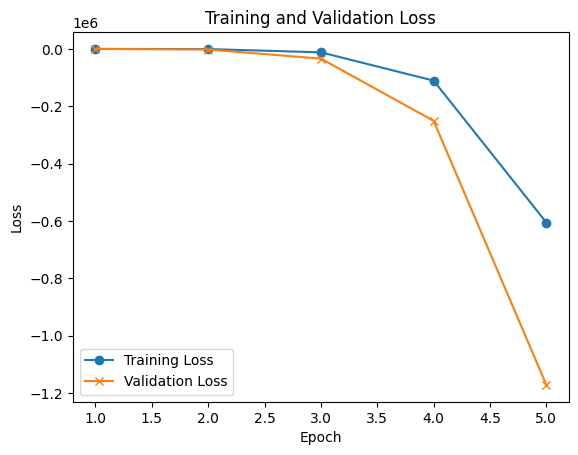

In [12]:
epochs=5

lenet_ns.train(data.train_loader, data.test_loader, epochs=epochs)
lenet_ns.evaluate(data.test_loader)

In [13]:
epochs=20
print('------------------------------------- LeNet -------------------------------------')
lenet.train(data.train_loader, data.test_loader, epochs=epochs)
print('----------------------------------- LeNet_nap -----------------------------------')
lenet_nap.train(data.train_loader, data.test_loader, epochs=epochs)
print('------------------------------------ LeNet_b ------------------------------------')
lenet_b.train(data.train_loader, data.test_loader, epochs=epochs)

------------------------------------- LeNet -------------------------------------
Epoch 1, Training Loss: 2.182906494140625, Validation Loss: 1.9926976919174195
Epoch 2, Training Loss: 1.9250093603134155, Validation Loss: 1.849894142150879
Epoch 3, Training Loss: 1.8051992225646973, Validation Loss: 1.7510840177536011
Epoch 4, Training Loss: 1.7197983026504517, Validation Loss: 1.6717755556106568
Epoch 5, Training Loss: 1.6546250486373901, Validation Loss: 1.620077919960022
Epoch 6, Training Loss: 1.5986725902557373, Validation Loss: 1.5678269863128662
Epoch 7, Training Loss: 1.5578498983383178, Validation Loss: 1.5465472221374512
Epoch 8, Training Loss: 1.5299932479858398, Validation Loss: 1.5130032300949097
Epoch 9, Training Loss: 1.5068160057067872, Validation Loss: 1.5048643827438355
Epoch 10, Training Loss: 1.480019302368164, Validation Loss: 1.4711202144622804
Epoch 11, Training Loss: 1.4616332626342774, Validation Loss: 1.4572837352752686
Epoch 12, Training Loss: 1.4398920440673

Accuracy: 52.05%
Precision: 0.5194591136257598
Recall: 0.5205
F1 Score: 0.5152557950706267


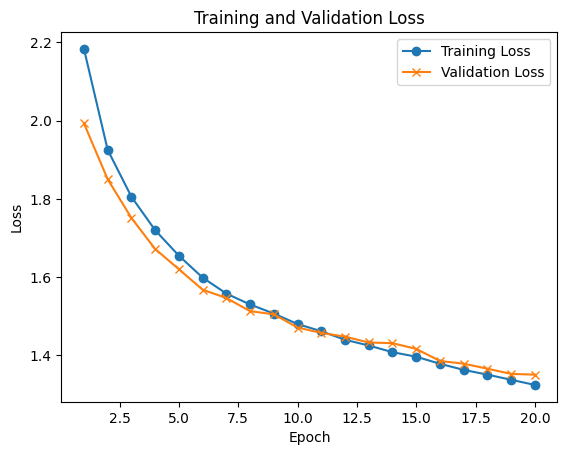

In [14]:
lenet.evaluate(data.test_loader)

Accuracy: 53.5%
Precision: 0.5360218992113462
Recall: 0.535
F1 Score: 0.5338904940091872


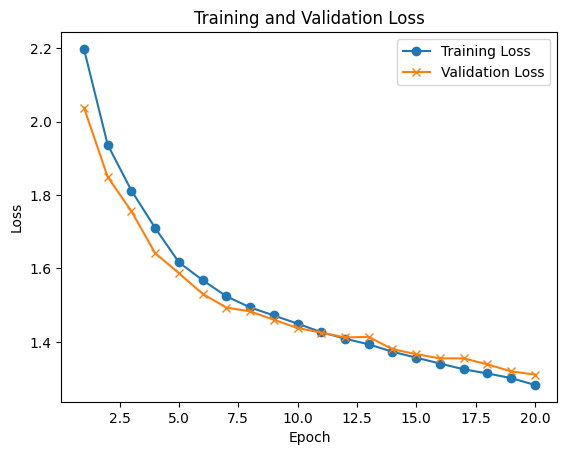

In [15]:
lenet_nap.evaluate(data.test_loader)

Accuracy: 73.15%
Precision: 0.7515767905647863
Recall: 0.7315
F1 Score: 0.730682249862934


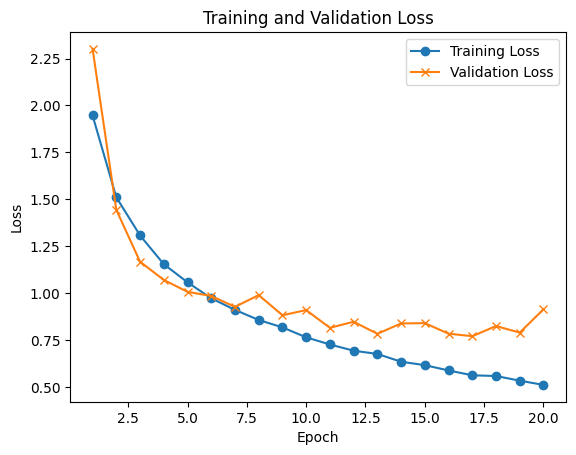

In [16]:
lenet_b.evaluate(data.test_loader)

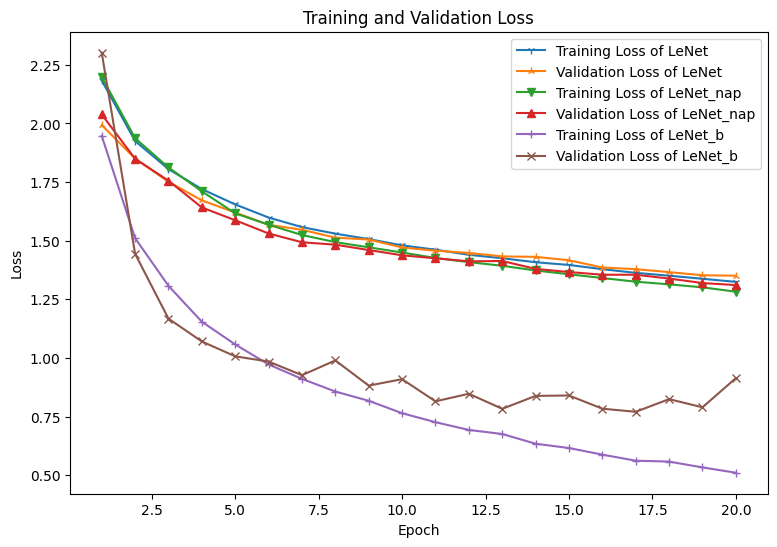

In [17]:
plt.figure(figsize=(9, 6))

plt.plot(range(1, len(lenet.training_losses) + 1), lenet.training_losses, label='Training Loss of LeNet', marker='1')
plt.plot(range(1, len(lenet.validation_losses) + 1), lenet.validation_losses, label='Validation Loss of LeNet', marker='2')
plt.plot(range(1, len(lenet_nap.training_losses) + 1), lenet_nap.training_losses, label='Training Loss of LeNet_nap', marker='v')
plt.plot(range(1, len(lenet_nap.validation_losses) + 1), lenet_nap.validation_losses, label='Validation Loss of LeNet_nap', marker='^')
plt.plot(range(1, len(lenet_b.training_losses) + 1), lenet_b.training_losses, label='Training Loss of LeNet_b', marker='+')
plt.plot(range(1, len(lenet_b.validation_losses) + 1), lenet_b.validation_losses, label='Validation Loss of LeNet_b', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

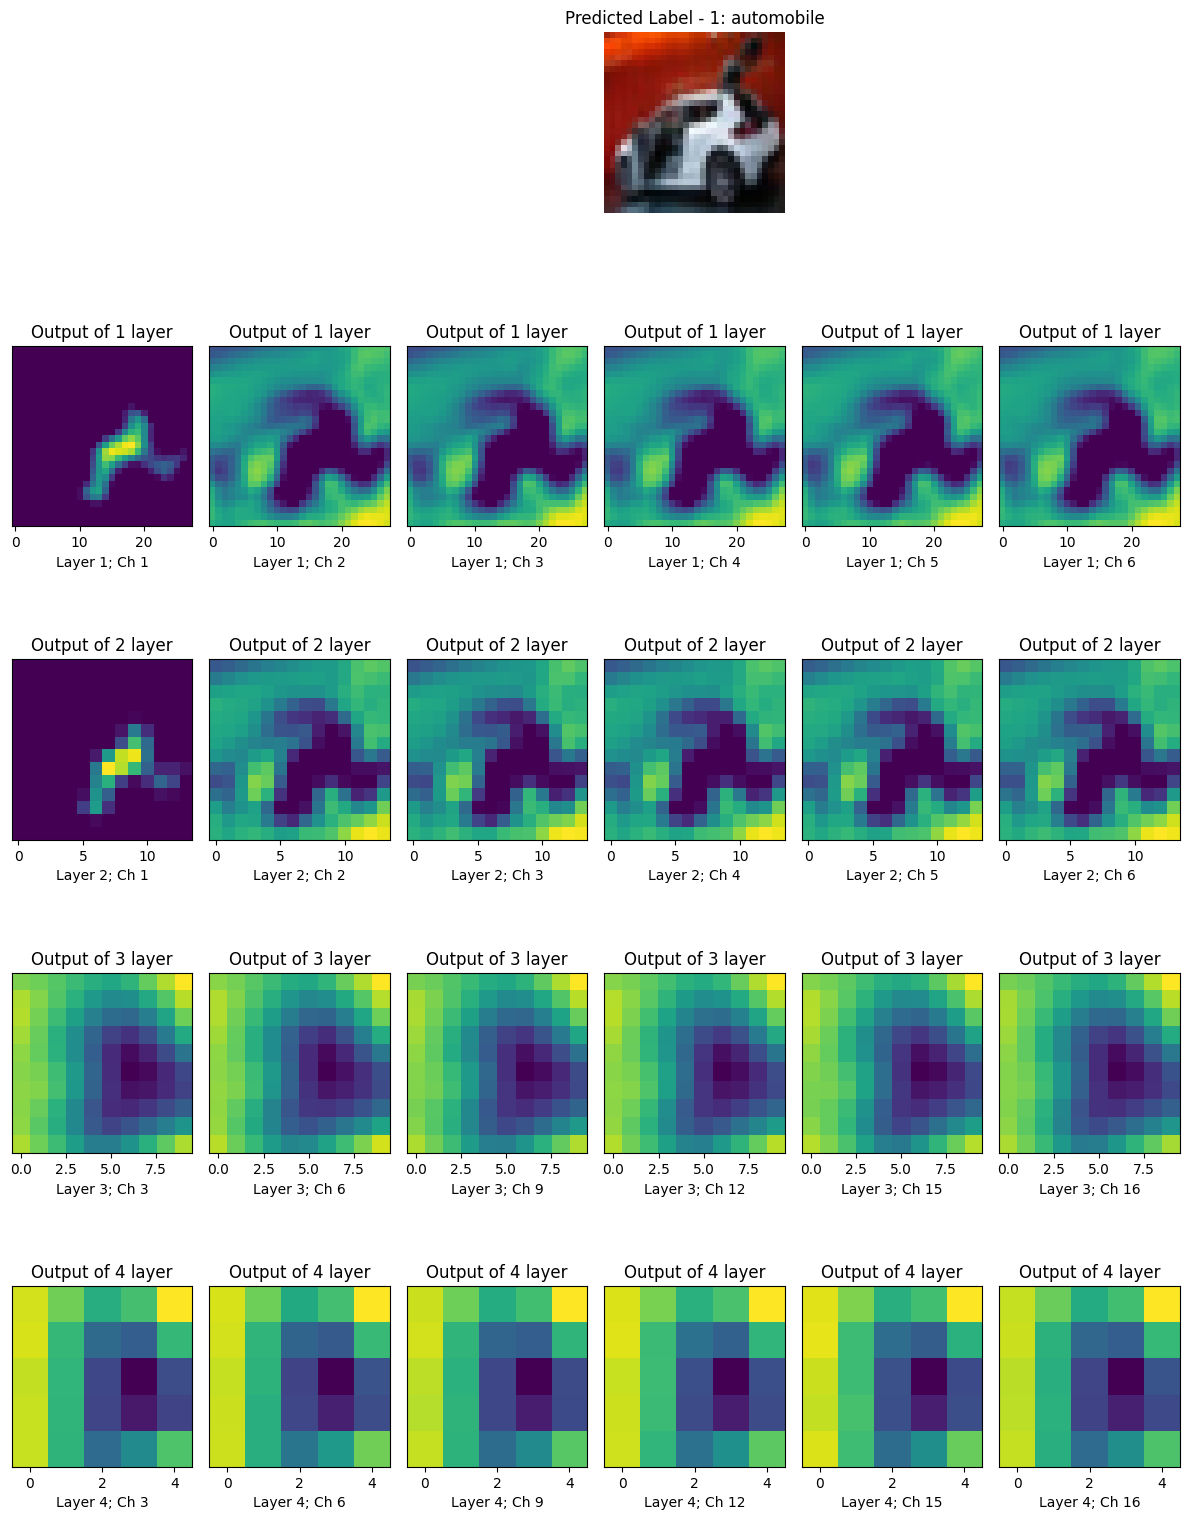

In [18]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[6]
predicted_label, layers_output = lenet_ns.predict(example_image)
visualize(data.class_names, example_image, predicted_label, layers_output, number_of_plots_in_row = 6)

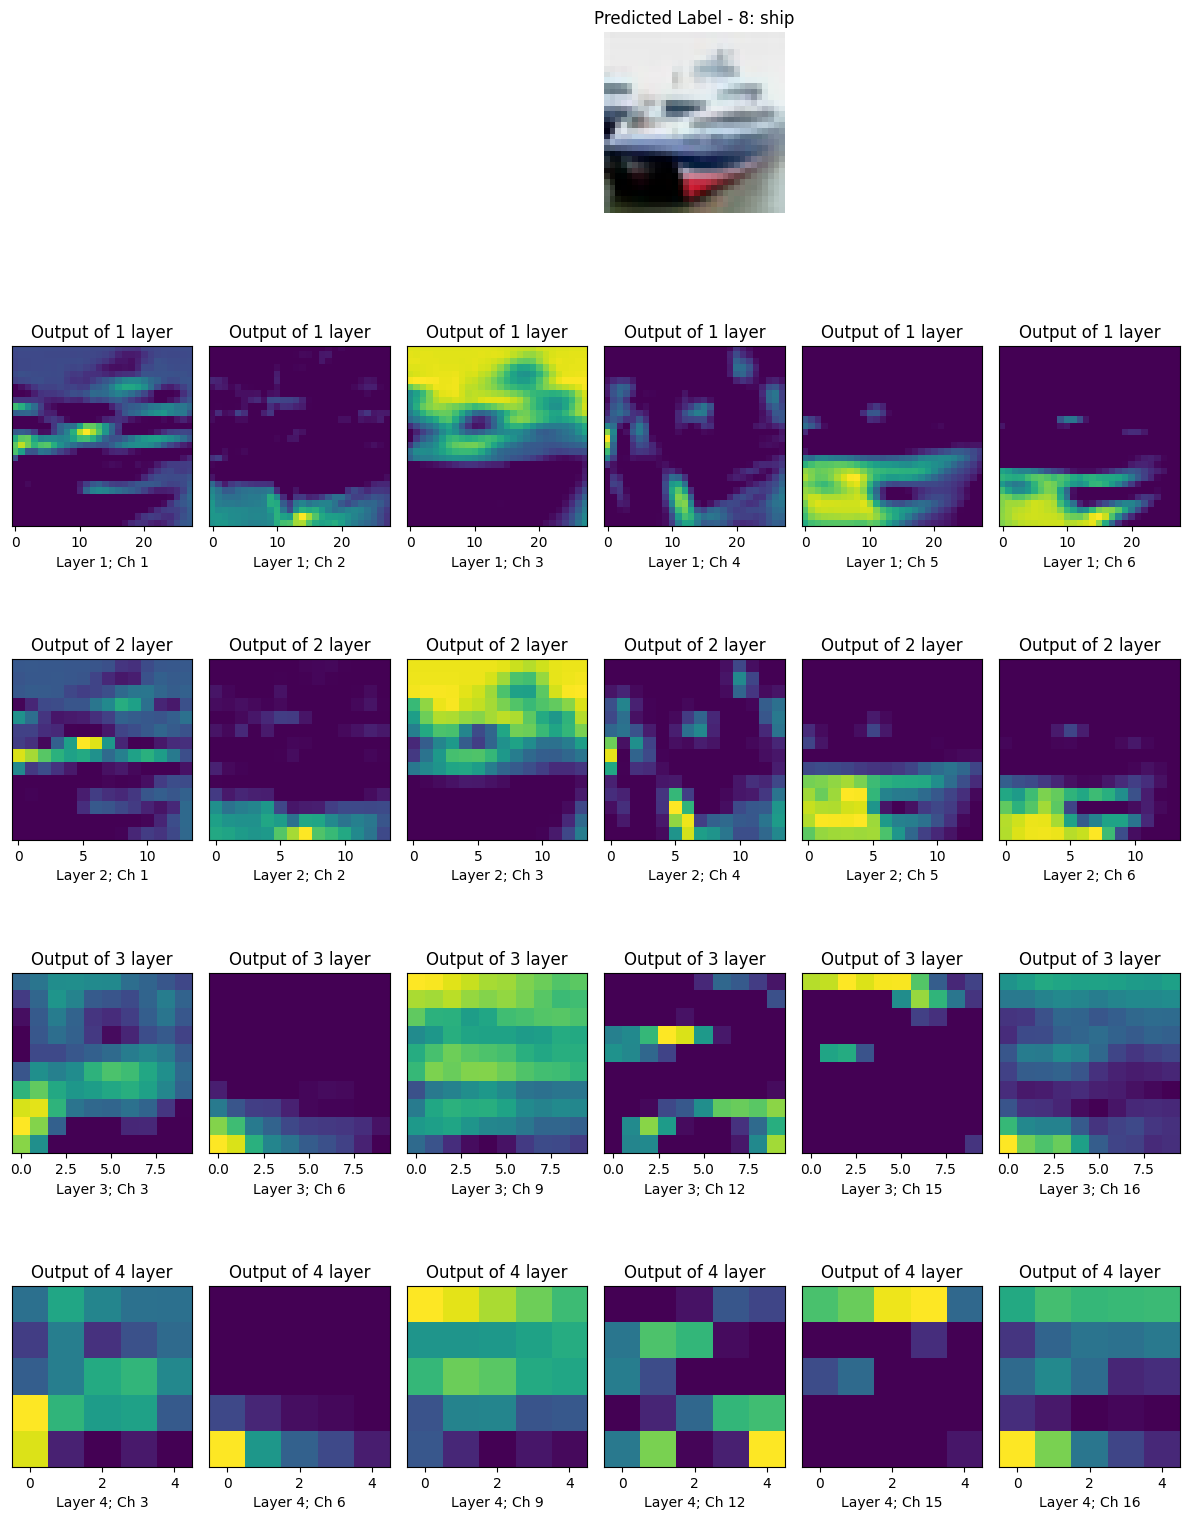

In [19]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[1]
predicted_label, layers_output = lenet.predict(example_image)
visualize(data.class_names, example_image, predicted_label, layers_output, number_of_plots_in_row = 6)

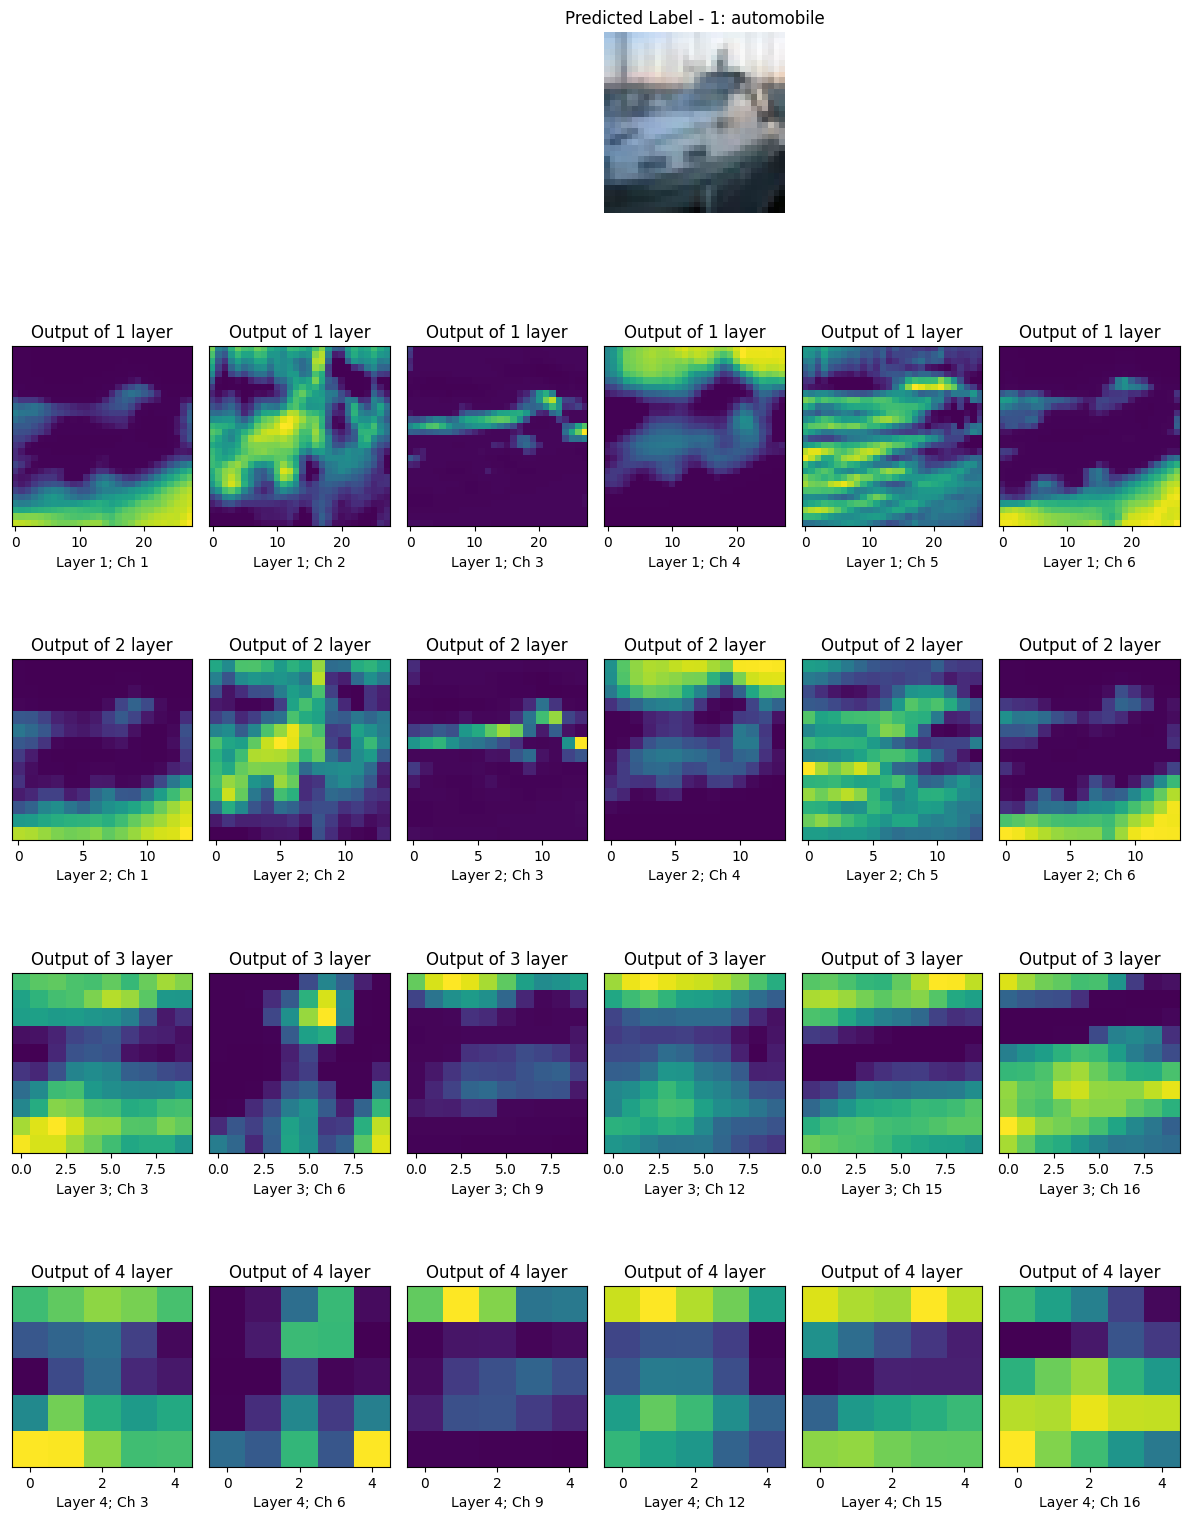

In [20]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[2]
predicted_label, layers_output = lenet_nap.predict(example_image)
visualize(data.class_names, example_image, predicted_label, layers_output, number_of_plots_in_row = 6)

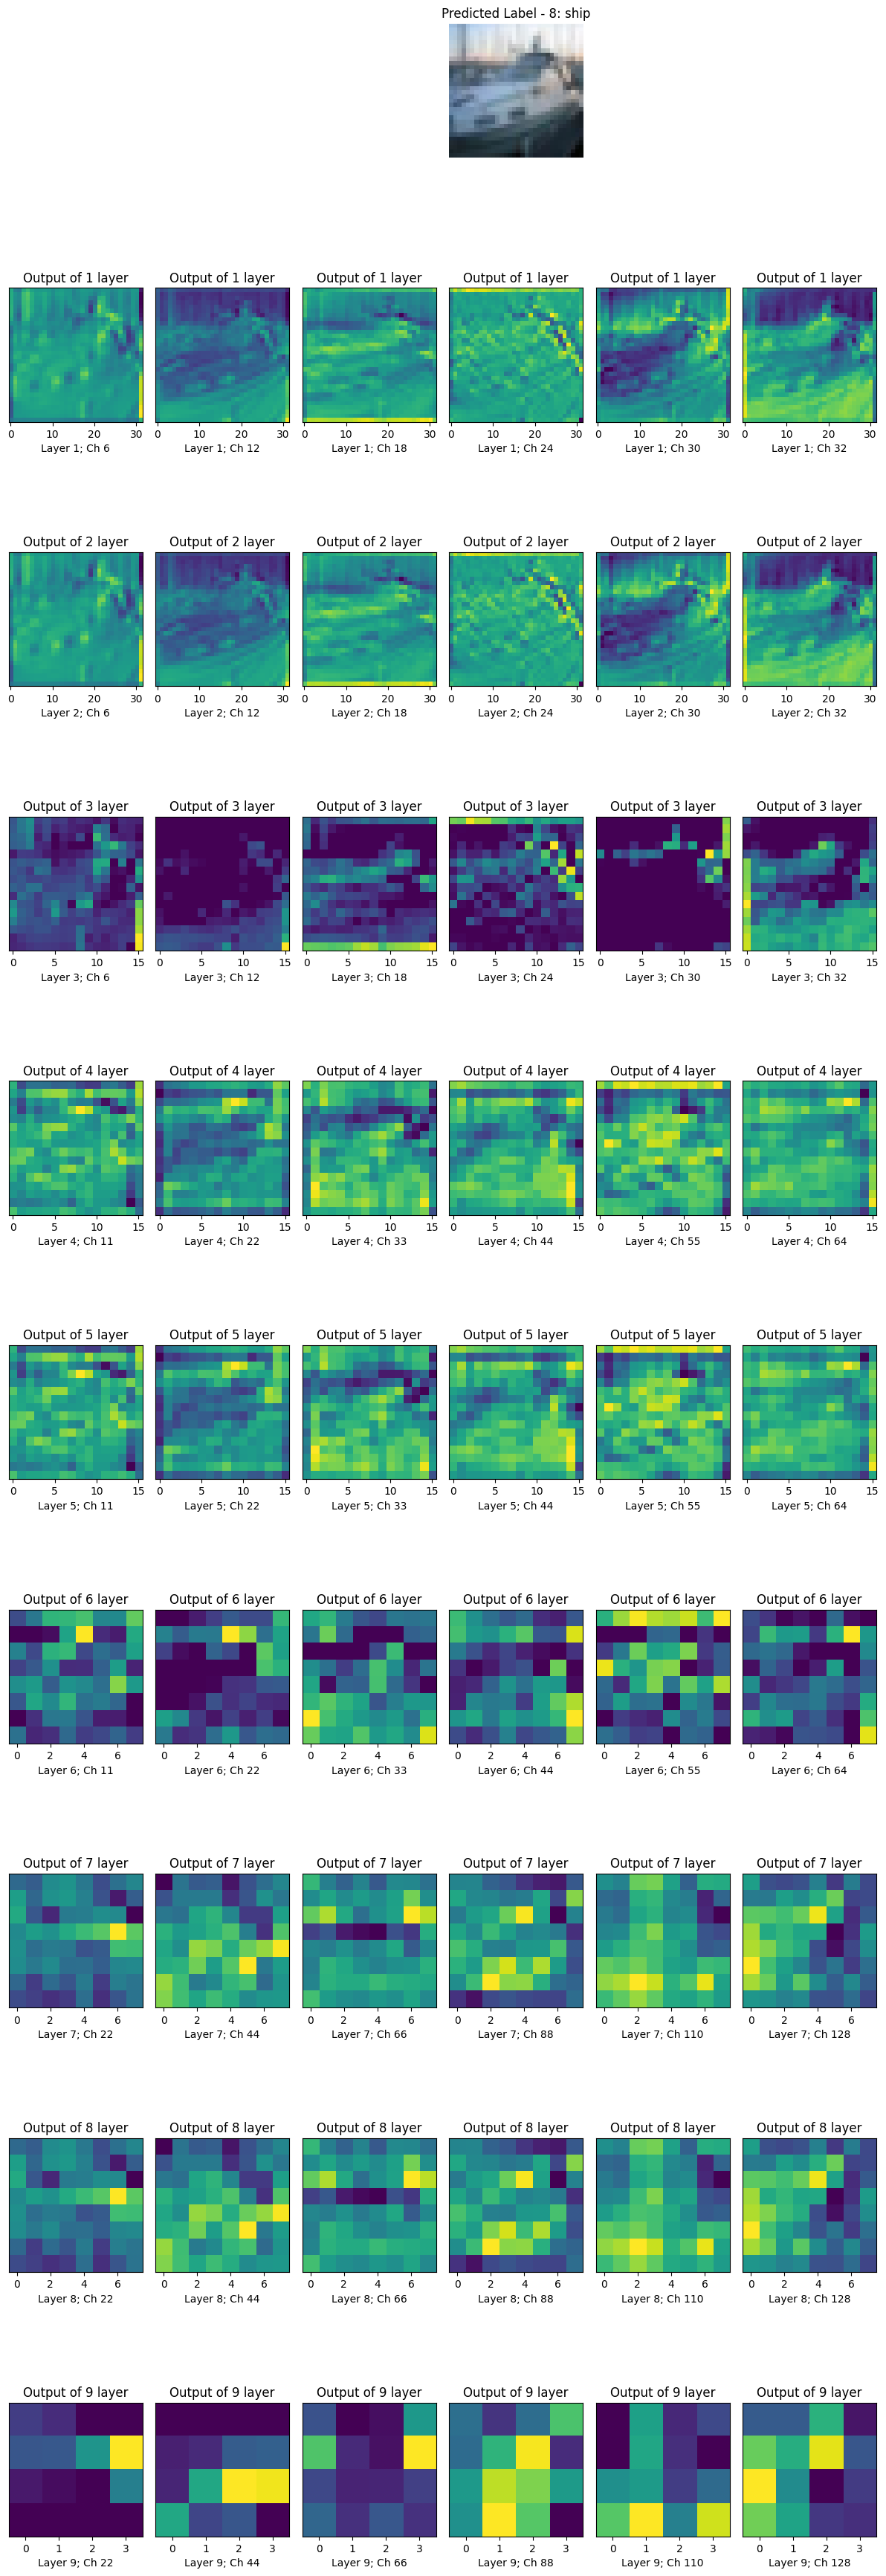

In [21]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[2]
predicted_label, layers_output = lenet_b.predict(example_image)
visualize(data.class_names, example_image, predicted_label, layers_output, number_of_plots_in_row = 6)

## MNIST

In [ ]:
data = DataLoaderWrapMNIST(batch = 2048)
lenet = ModelUtils(LeNet(len(data.class_names), CIFAR = False), learning_rate=0.001)
lenet_ns = ModelUtils(LeNet_no_softmax(len(data.class_names), CIFAR = False), learning_rate=0.001)
lenet_nap = ModelUtils(LeNet_new_act_and_pool(len(data.class_names), CIFAR = False), learning_rate=0.001)
lenet_b = ModelUtils(BoostedLeNet(len(data.class_names), CIFAR = False), learning_rate=0.001)

Epoch 1, Training Loss: -12.472869701776654, Validation Loss: -88.28568420410156
Epoch 2, Training Loss: -1778.651010386149, Validation Loss: -7328.08955078125
Epoch 3, Training Loss: -44257.18077799479, Validation Loss: -129643.5515625
Epoch 4, Training Loss: -437077.74166666664, Validation Loss: -1003496.05
Epoch 5, Training Loss: -2433031.8833333333, Validation Loss: -4726217.3
Accuracy: 10.28%
Precision: 0.01056784
Recall: 0.1028
F1 Score: 0.019165469713456652


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


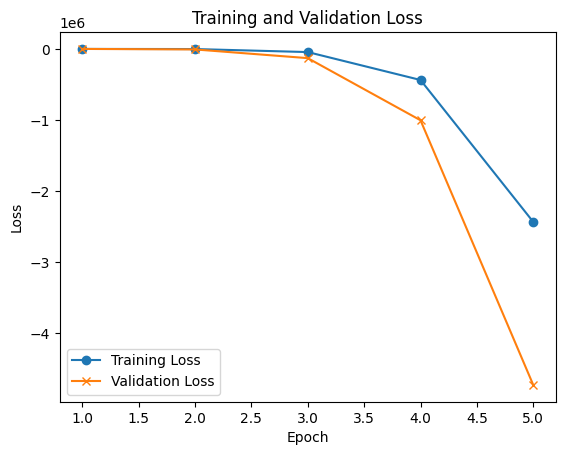

In [23]:
epochs=5

lenet_ns.train(data.train_loader, data.test_loader, epochs=epochs)
lenet_ns.evaluate(data.test_loader)

In [24]:
epochs=20
print('------------------------------------- LeNet -------------------------------------')
lenet.train(data.train_loader, data.test_loader, epochs=epochs)
print('----------------------------------- LeNet_nap -----------------------------------')
lenet_nap.train(data.train_loader, data.test_loader, epochs=epochs)
print('------------------------------------ LeNet_b ------------------------------------')
lenet_b.train(data.train_loader, data.test_loader, epochs=epochs)

------------------------------------- LeNet -------------------------------------
Epoch 1, Training Loss: 1.85525776942571, Validation Loss: 0.924158263206482
Epoch 2, Training Loss: 0.6180950035651525, Validation Loss: 0.45863995552062986
Epoch 3, Training Loss: 0.4226069837808609, Validation Loss: 0.35201451778411863
Epoch 4, Training Loss: 0.3445568213860194, Validation Loss: 0.2925103515386581
Epoch 5, Training Loss: 0.2904215132196744, Validation Loss: 0.24422559142112732
Epoch 6, Training Loss: 0.24370010942220688, Validation Loss: 0.2008949875831604
Epoch 7, Training Loss: 0.20452961176633835, Validation Loss: 0.16881248503923416
Epoch 8, Training Loss: 0.17258348365624746, Validation Loss: 0.14676589965820314
Epoch 9, Training Loss: 0.150993529210488, Validation Loss: 0.1224139004945755
Epoch 10, Training Loss: 0.1324208065867424, Validation Loss: 0.10616574212908744
Epoch 11, Training Loss: 0.11810178433855374, Validation Loss: 0.09582294449210167
Epoch 12, Training Loss: 0.10

Accuracy: 98.14%
Precision: 0.9814708757740759
Recall: 0.9814
F1 Score: 0.9813759784014743


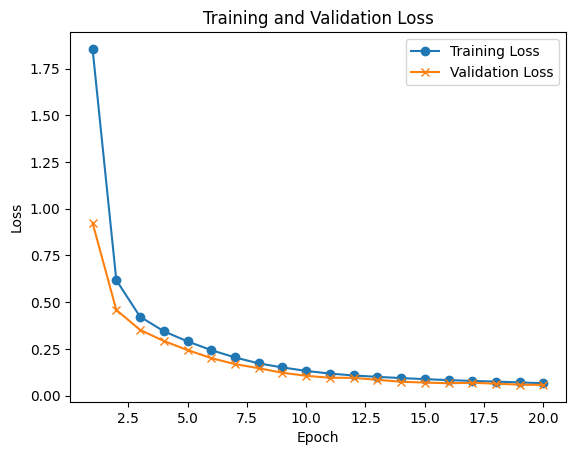

In [25]:
lenet.evaluate(data.test_loader)

Accuracy: 98.09%
Precision: 0.9810059184941576
Recall: 0.9809
F1 Score: 0.9809092030161412


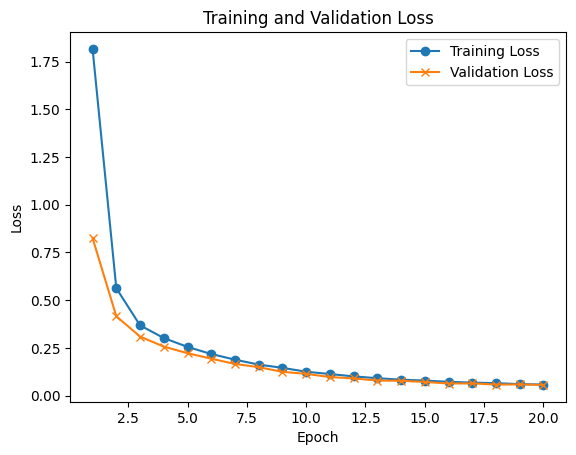

In [26]:
lenet_nap.evaluate(data.test_loader)

Accuracy: 99.13%
Precision: 0.9913548812208414
Recall: 0.9913
F1 Score: 0.9912902201963909


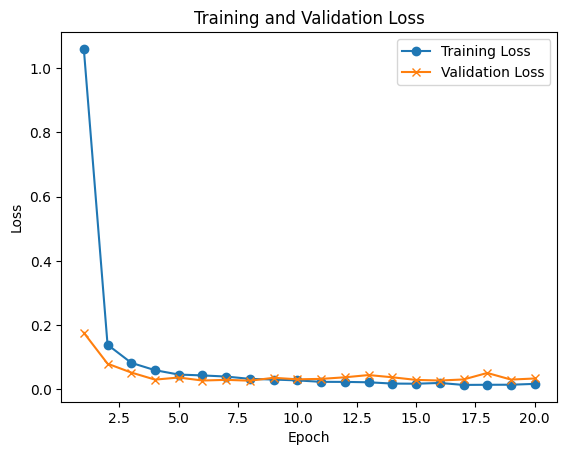

In [27]:
lenet_b.evaluate(data.test_loader)

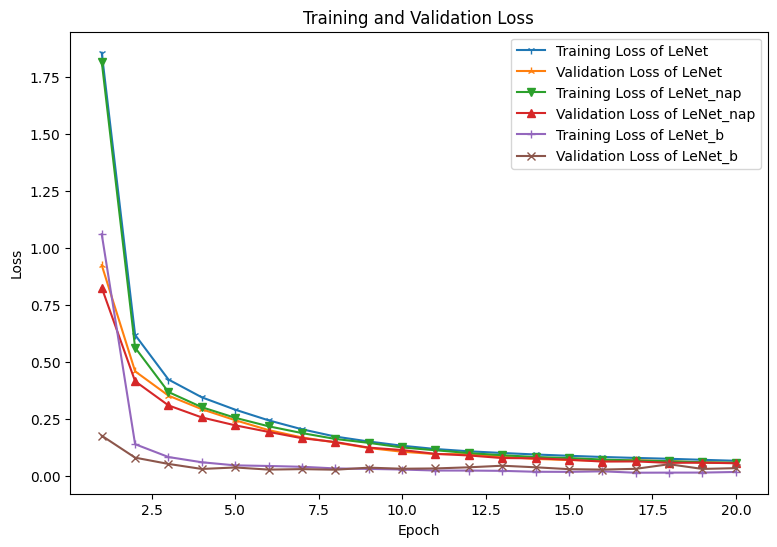

In [28]:
plt.figure(figsize=(9, 6))

plt.plot(range(1, len(lenet.training_losses) + 1), lenet.training_losses, label='Training Loss of LeNet', marker='1')
plt.plot(range(1, len(lenet.training_losses) + 1), lenet.validation_losses, label='Validation Loss of LeNet', marker='2')
plt.plot(range(1, len(lenet_nap.training_losses) + 1), lenet_nap.training_losses, label='Training Loss of LeNet_nap', marker='v')
plt.plot(range(1, len(lenet_nap.training_losses) + 1), lenet_nap.validation_losses, label='Validation Loss of LeNet_nap', marker='^')
plt.plot(range(1, len(lenet_b.training_losses) + 1), lenet_b.training_losses, label='Training Loss of LeNet_b', marker='+')
plt.plot(range(1, len(lenet_b.training_losses) + 1), lenet_b.validation_losses, label='Validation Loss of LeNet_b', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

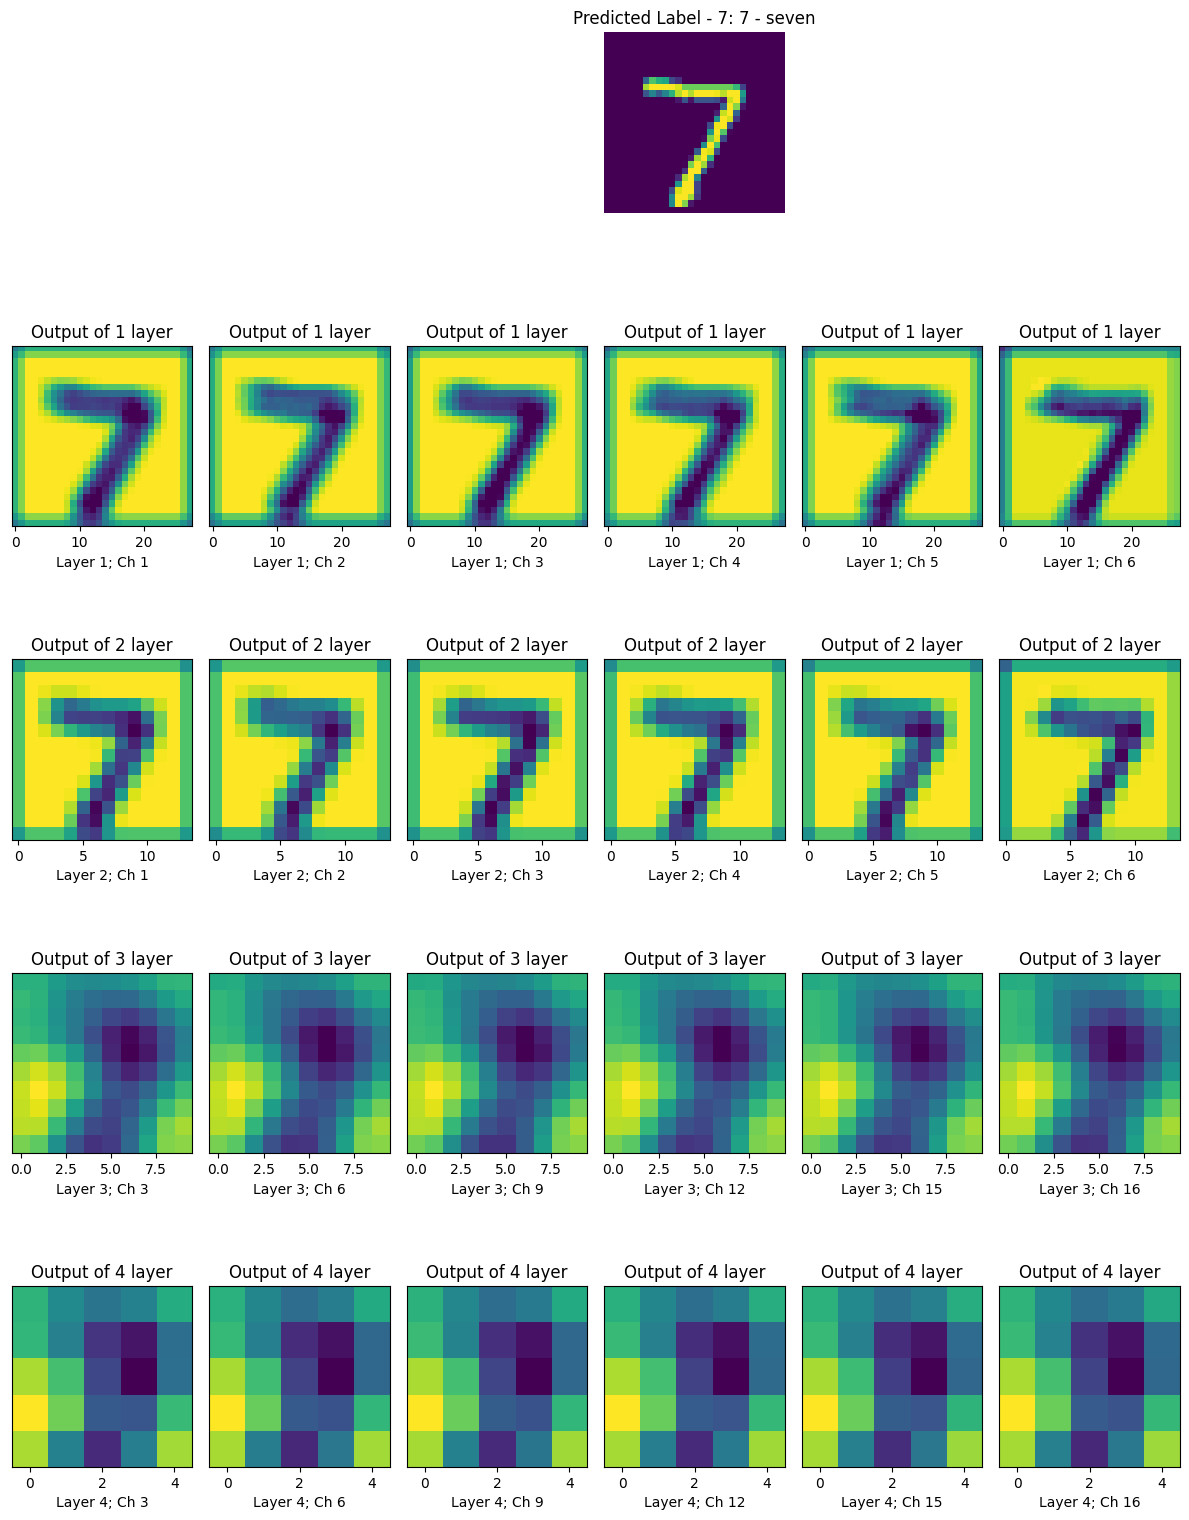

In [29]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[0]
predicted_label, layers_output = lenet_ns.predict(example_image)
visualize(data.class_names, example_image, predicted_label, layers_output, number_of_plots_in_row = 6)

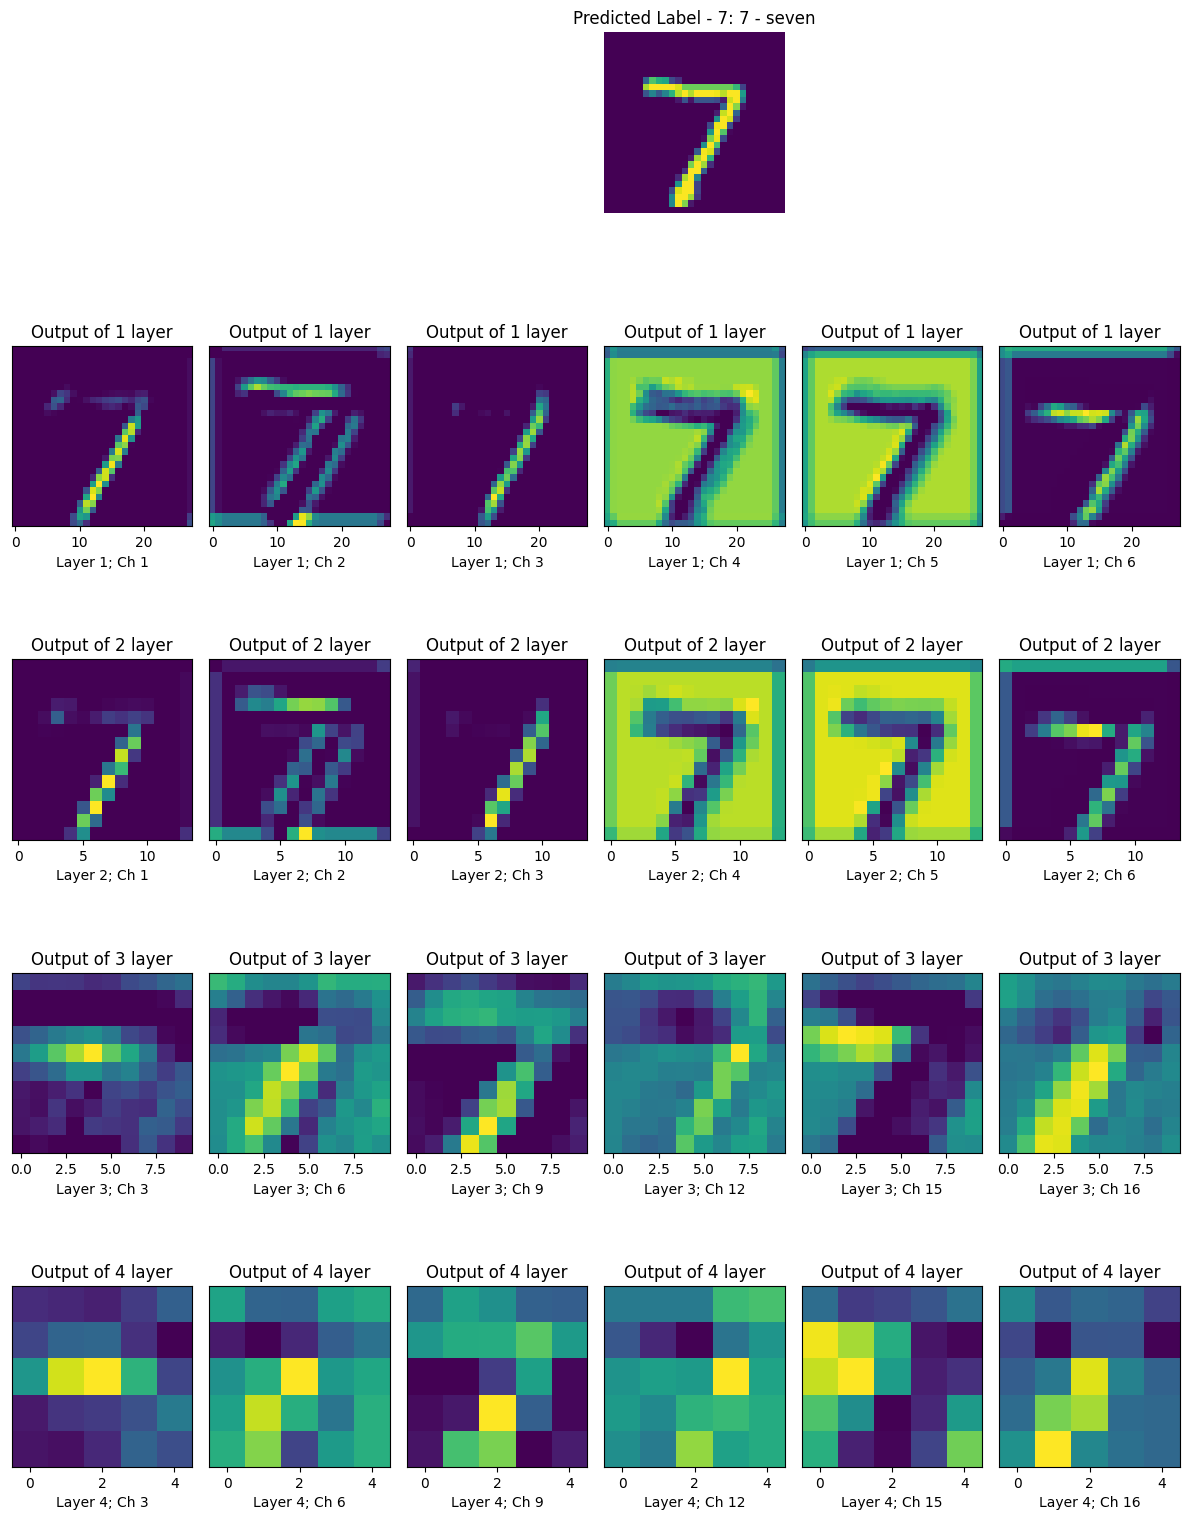

In [30]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[0]
predicted_label, layers_output = lenet.predict(example_image)
visualize(data.class_names, example_image, predicted_label, layers_output, number_of_plots_in_row = 6)

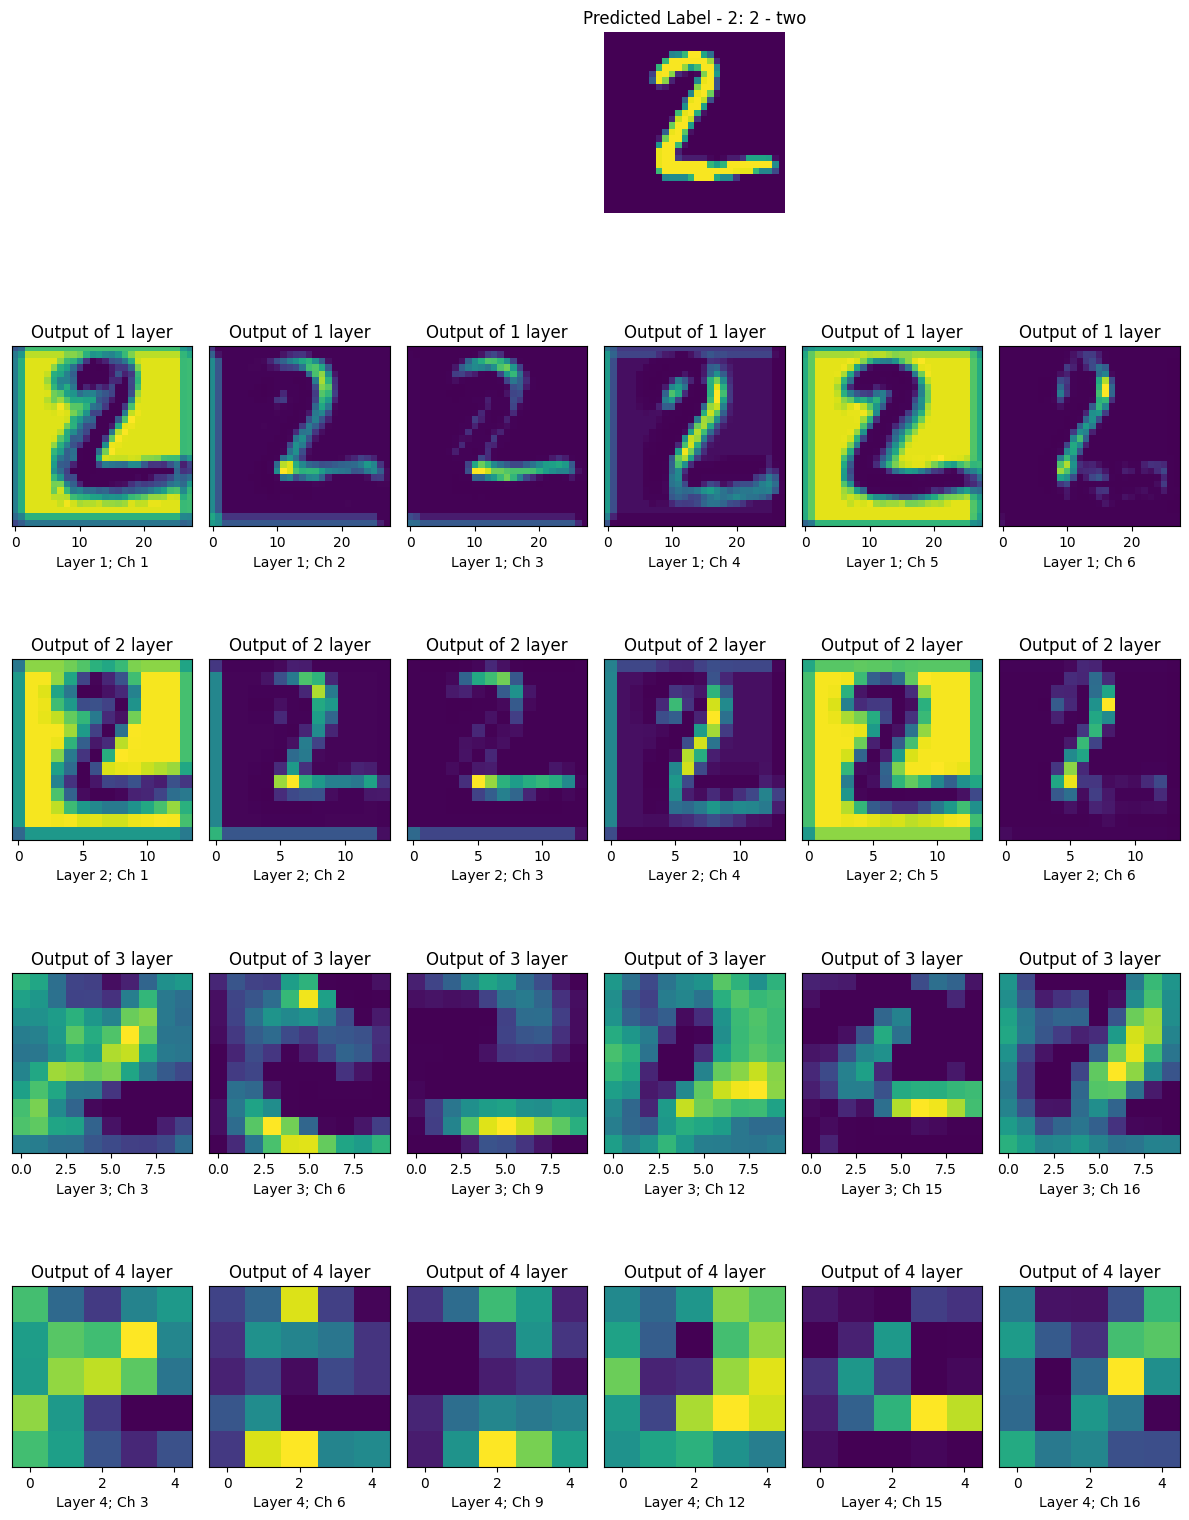

In [31]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[1]
predicted_label, layers_output = lenet_nap.predict(example_image)
visualize(data.class_names, example_image, predicted_label, layers_output, number_of_plots_in_row = 6)

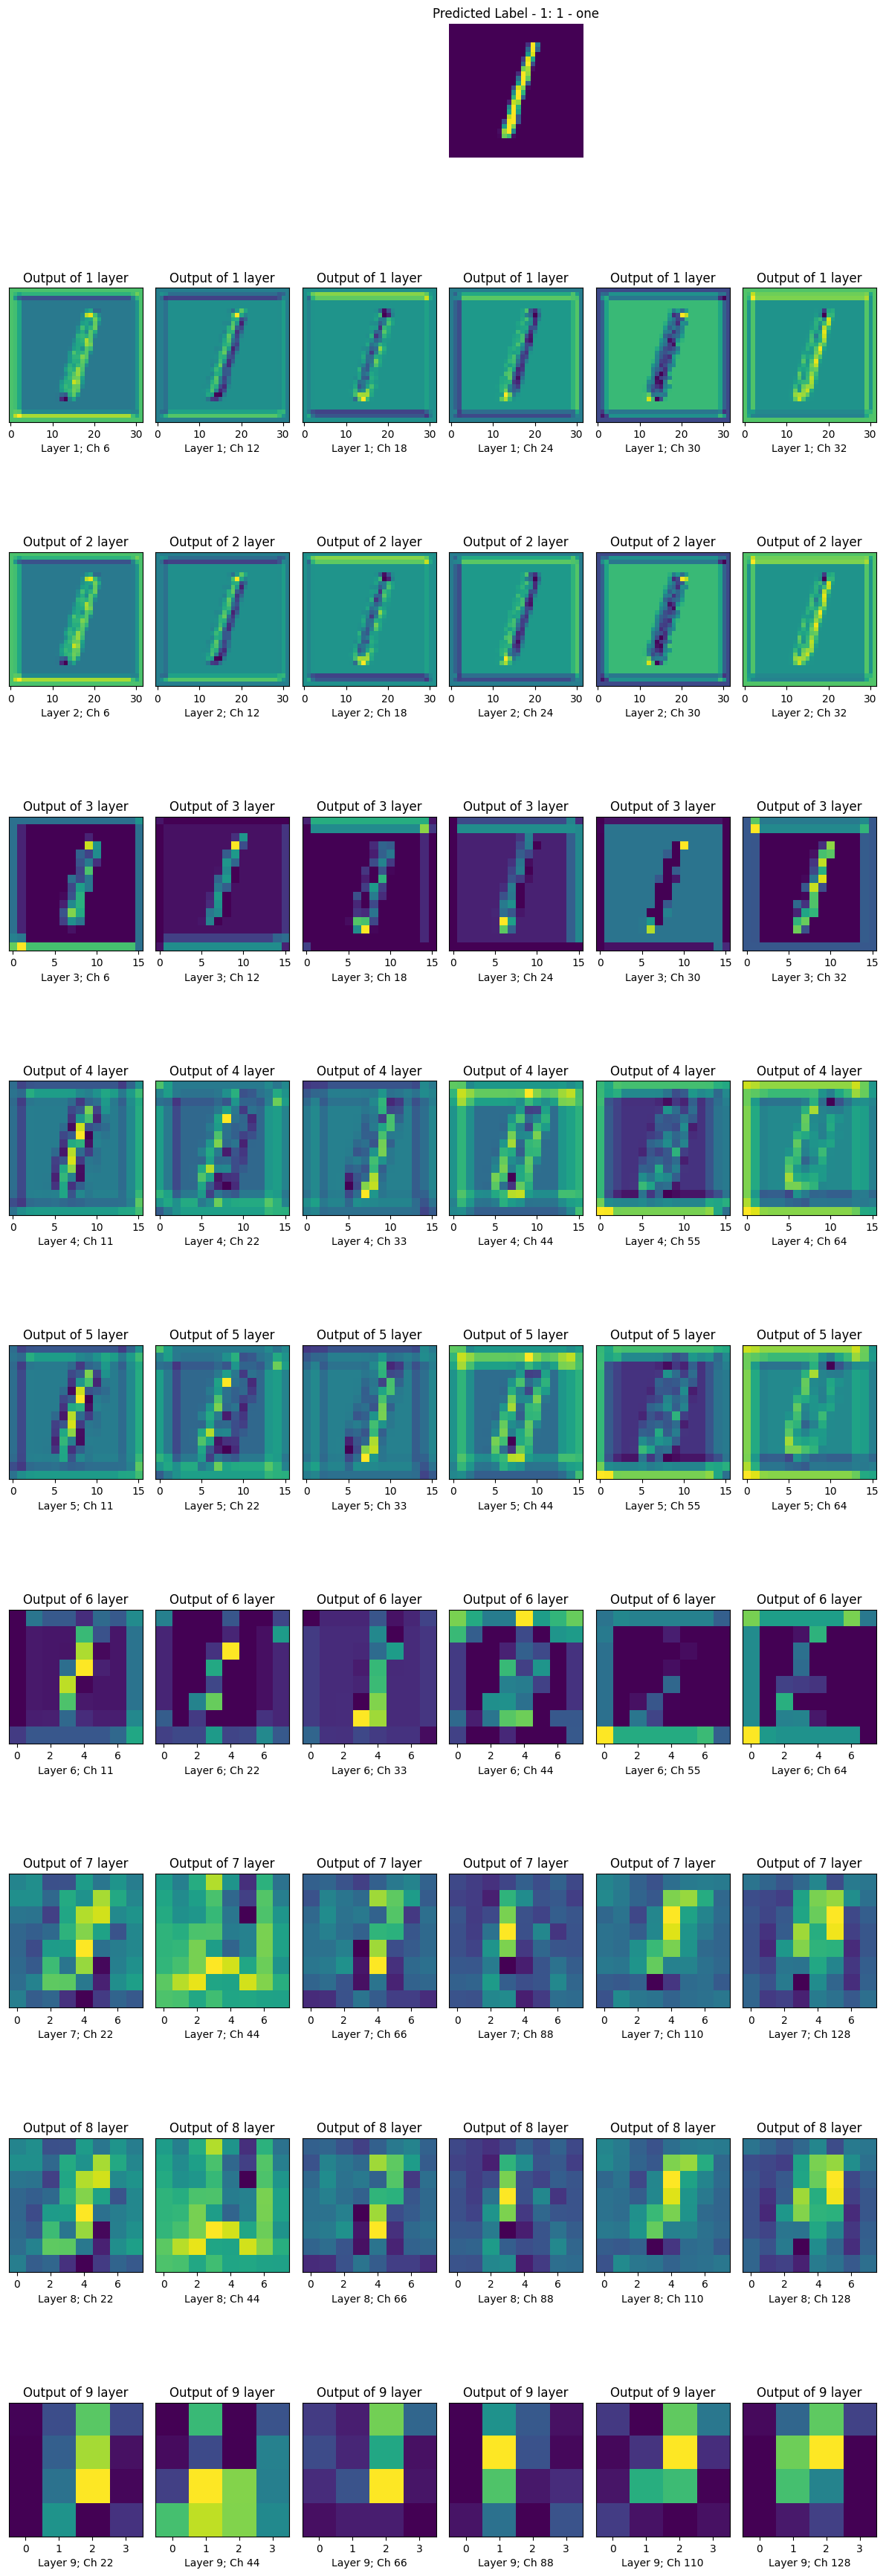

In [32]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[2]
predicted_label, layers_output = lenet_b.predict(example_image)
visualize(data.class_names, example_image, predicted_label, layers_output, number_of_plots_in_row = 6)

## EMNIST

In [33]:
data = DataLoaderWrapEMNIST(batch = 2048)
lenet = ModelUtils(LeNet(len(data.class_names), CIFAR = False), learning_rate=0.001)
lenet_ns = ModelUtils(LeNet_no_softmax(len(data.class_names), CIFAR = False), learning_rate=0.001)
lenet_nap = ModelUtils(LeNet_new_act_and_pool(len(data.class_names), CIFAR = False), learning_rate=0.001)
lenet_b = ModelUtils(BoostedLeNet(len(data.class_names), CIFAR = False), learning_rate=0.001)

100%|██████████| 562M/562M [00:35<00:00, 15.7MB/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


Epoch 1, Training Loss: -561.8978241965272, Validation Loss: -4440.81807084517
Epoch 2, Training Loss: -128108.23950595543, Validation Loss: -534080.0596590909
Epoch 3, Training Loss: -3252072.3155737706, Validation Loss: -9026254.045454545
Epoch 4, Training Loss: -28009651.213114753, Validation Loss: -59847921.09090909
Epoch 5, Training Loss: -133456055.86885247, Validation Loss: -241437378.9090909
Accuracy: 3.8461538461538463%
Precision: 0.0014792899408284023
Recall: 0.038461538461538464
F1 Score: 0.0028490028490028487


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


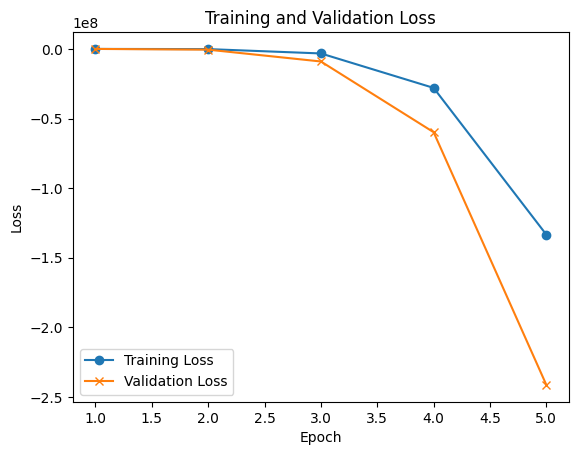

In [34]:
epochs=5

lenet_ns.train(data.train_loader, data.test_loader, epochs=epochs)
lenet_ns.evaluate(data.test_loader)

In [35]:
epochs=20
print('------------------------------------- LeNet -------------------------------------')
lenet.train(data.train_loader, data.test_loader, epochs=epochs)
print('----------------------------------- LeNet_nap -----------------------------------')
lenet_nap.train(data.train_loader, data.test_loader, epochs=epochs)
print('------------------------------------ LeNet_b ------------------------------------')
lenet_b.train(data.train_loader, data.test_loader, epochs=epochs)

------------------------------------- LeNet -------------------------------------
Epoch 1, Training Loss: 2.3043612632595125, Validation Loss: 1.4380522207780317
Epoch 2, Training Loss: 1.131906056990389, Validation Loss: 0.9270059791478243
Epoch 3, Training Loss: 0.7846569907469828, Validation Loss: 0.6790403425693512
Epoch 4, Training Loss: 0.6122974421157211, Validation Loss: 0.5655353665351868
Epoch 5, Training Loss: 0.5149495958304796, Validation Loss: 0.49775473367084155
Epoch 6, Training Loss: 0.46050249308836266, Validation Loss: 0.4425026611848311
Epoch 7, Training Loss: 0.41909602577569055, Validation Loss: 0.4037478972565044
Epoch 8, Training Loss: 0.38536911030284693, Validation Loss: 0.3938646479086442
Epoch 9, Training Loss: 0.36142649025213525, Validation Loss: 0.3550380522554571
Epoch 10, Training Loss: 0.34307108208781384, Validation Loss: 0.3483497974547473
Epoch 11, Training Loss: 0.3260099350428972, Validation Loss: 0.33089410987767304
Epoch 12, Training Loss: 0.314

Accuracy: 91.4423076923077%
Precision: 0.9157859066915323
Recall: 0.9144230769230769
F1 Score: 0.9143744002520531


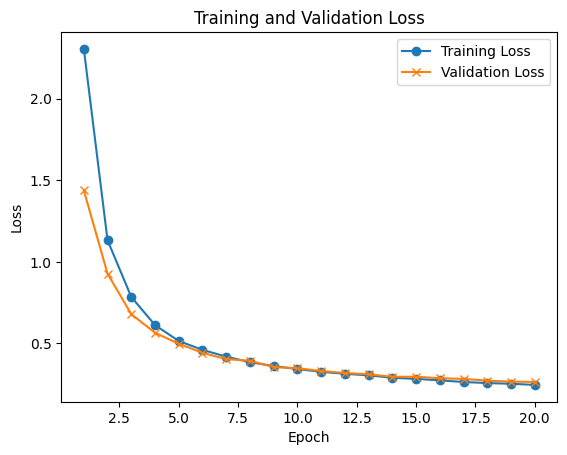

In [36]:
lenet.evaluate(data.test_loader)

Accuracy: 91.8173076923077%
Precision: 0.9185615139190121
Recall: 0.9181730769230769
F1 Score: 0.9178440994086335


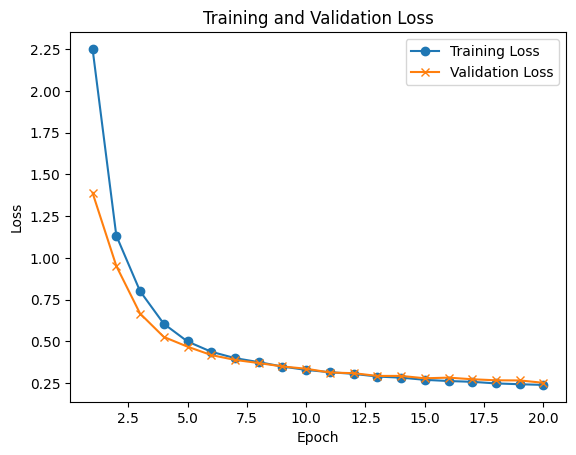

In [37]:
lenet_nap.evaluate(data.test_loader)

Accuracy: 94.46153846153847%
Precision: 0.9452524549431173
Recall: 0.9446153846153846
F1 Score: 0.9444918743481606


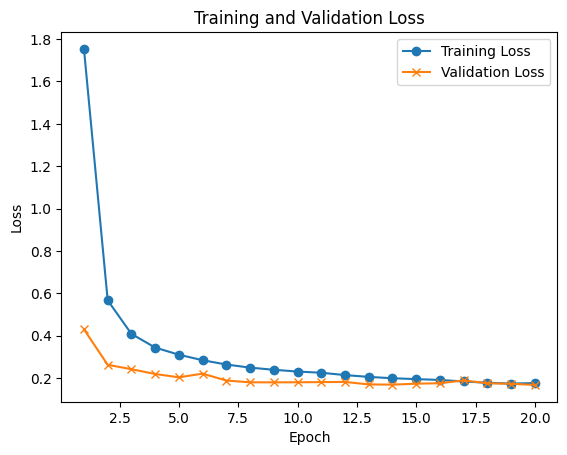

In [38]:
lenet_b.evaluate(data.test_loader)

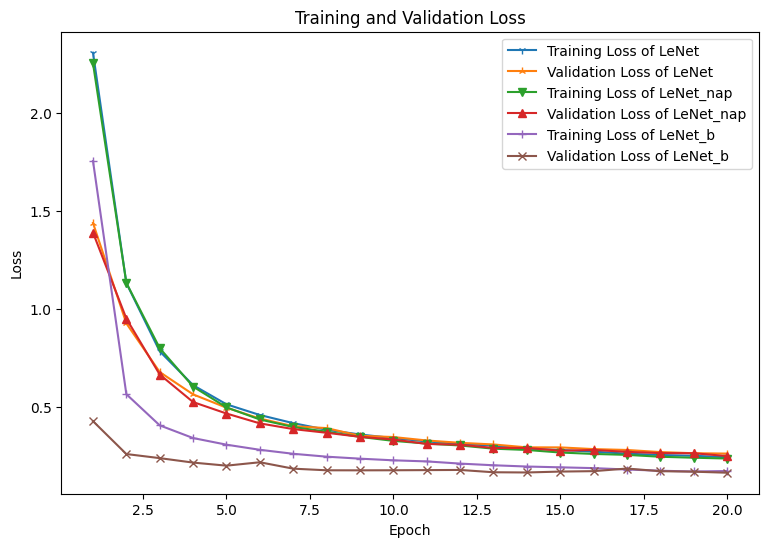

In [39]:
plt.figure(figsize=(9, 6))

plt.plot(range(1, len(lenet.training_losses) + 1), lenet.training_losses, label='Training Loss of LeNet', marker='1')
plt.plot(range(1, len(lenet.training_losses) + 1), lenet.validation_losses, label='Validation Loss of LeNet', marker='2')
plt.plot(range(1, len(lenet_nap.training_losses) + 1), lenet_nap.training_losses, label='Training Loss of LeNet_nap', marker='v')
plt.plot(range(1, len(lenet_nap.training_losses) + 1), lenet_nap.validation_losses, label='Validation Loss of LeNet_nap', marker='^')
plt.plot(range(1, len(lenet_b.training_losses) + 1), lenet_b.training_losses, label='Training Loss of LeNet_b', marker='+')
plt.plot(range(1, len(lenet_b.training_losses) + 1), lenet_b.validation_losses, label='Validation Loss of LeNet_b', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

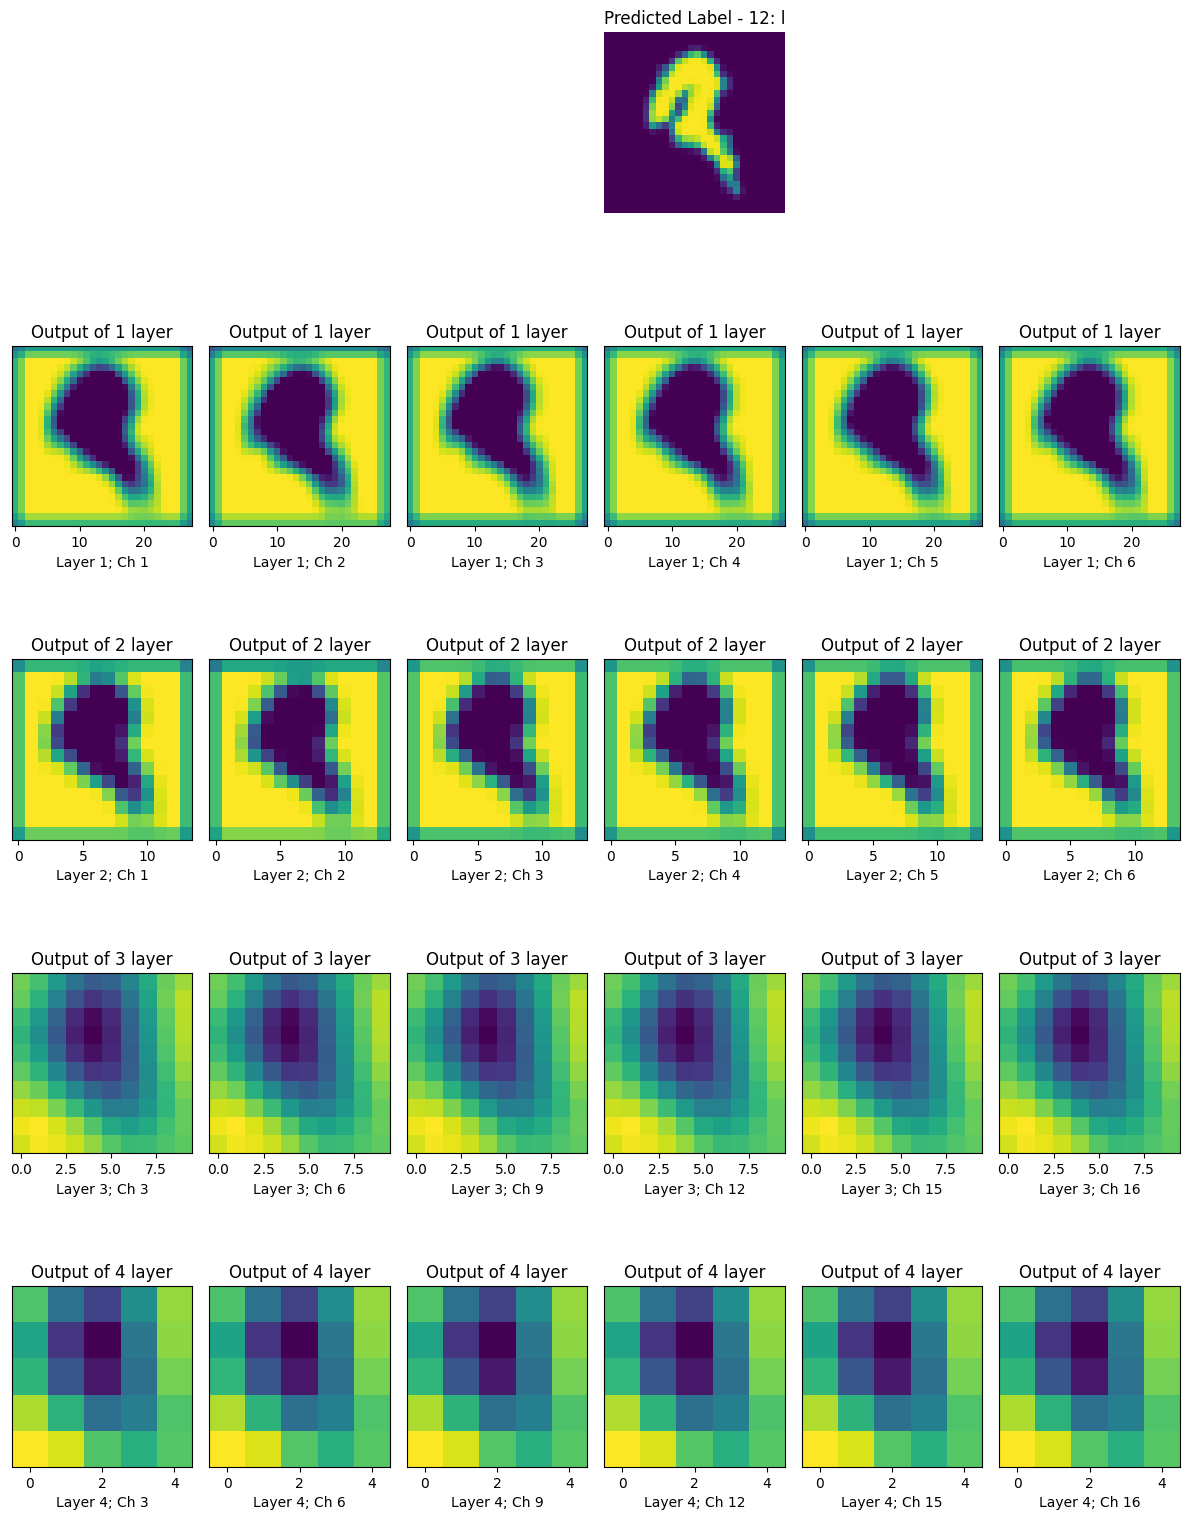

In [40]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[0]
predicted_label, layers_output = lenet_ns.predict(example_image)
visualize(data.class_names, example_image, predicted_label, layers_output, number_of_plots_in_row = 6)

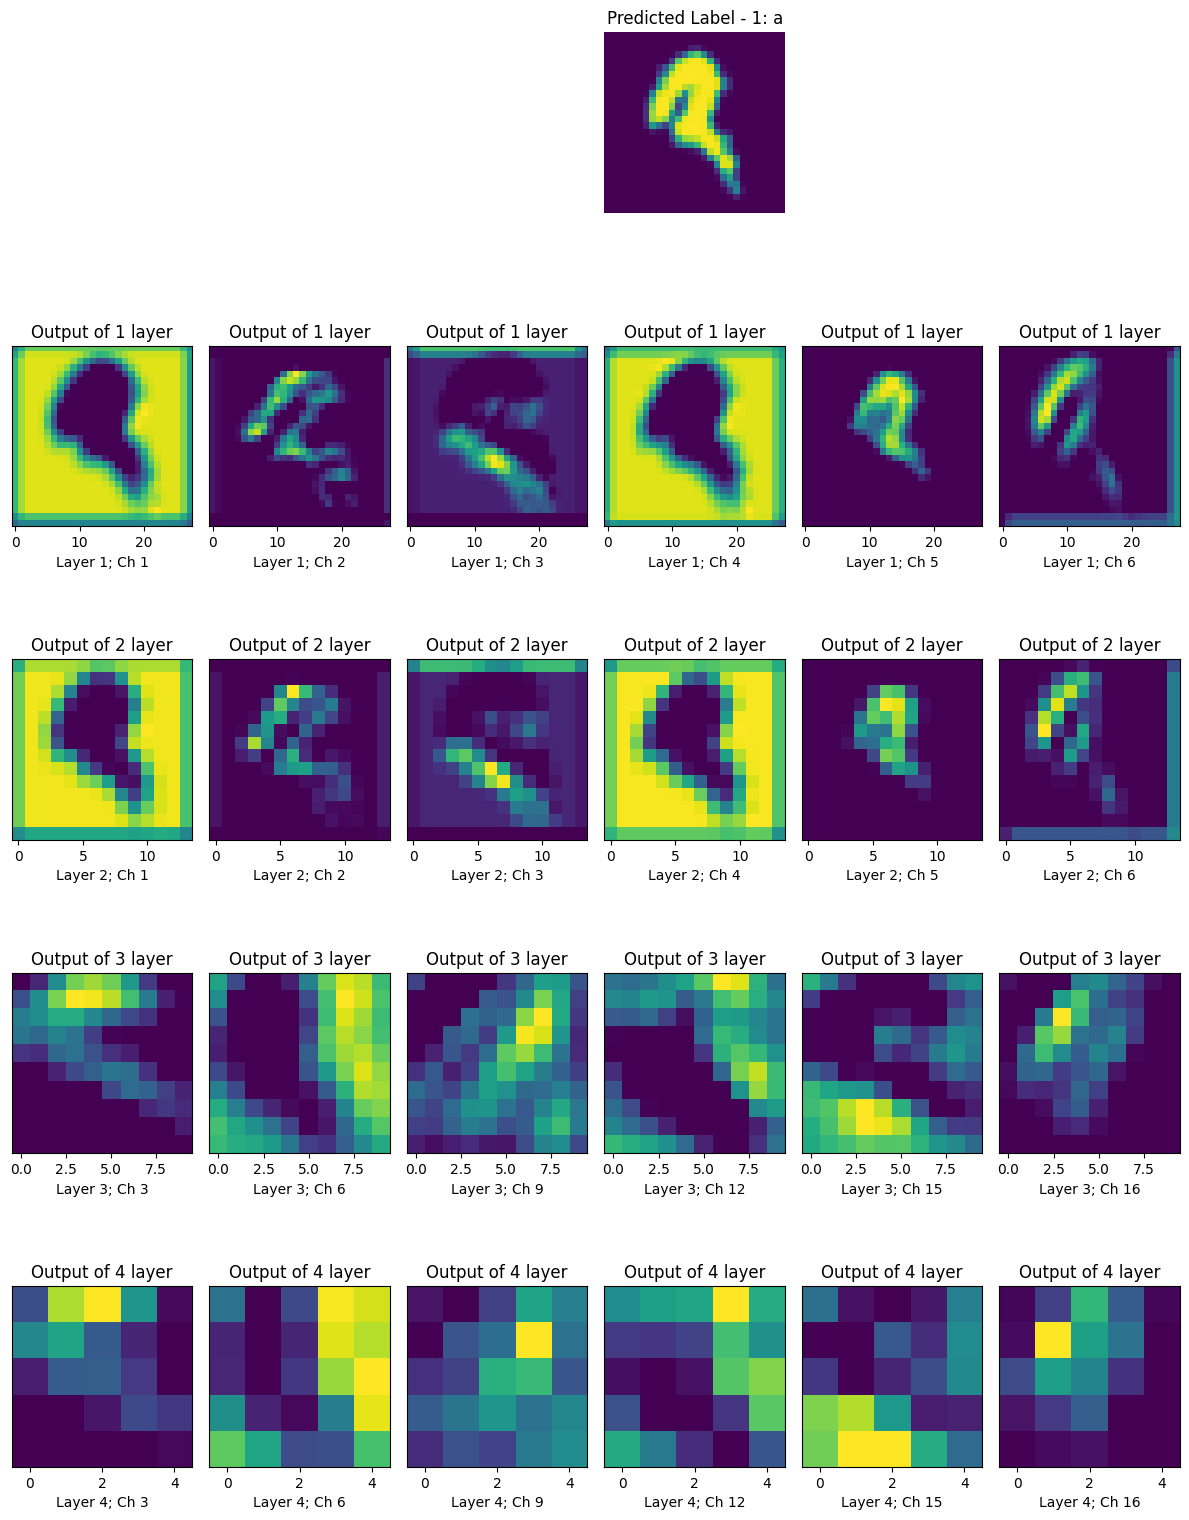

In [41]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[0]
predicted_label, layers_output = lenet.predict(example_image)
visualize(data.class_names, example_image, predicted_label, layers_output, number_of_plots_in_row = 6)

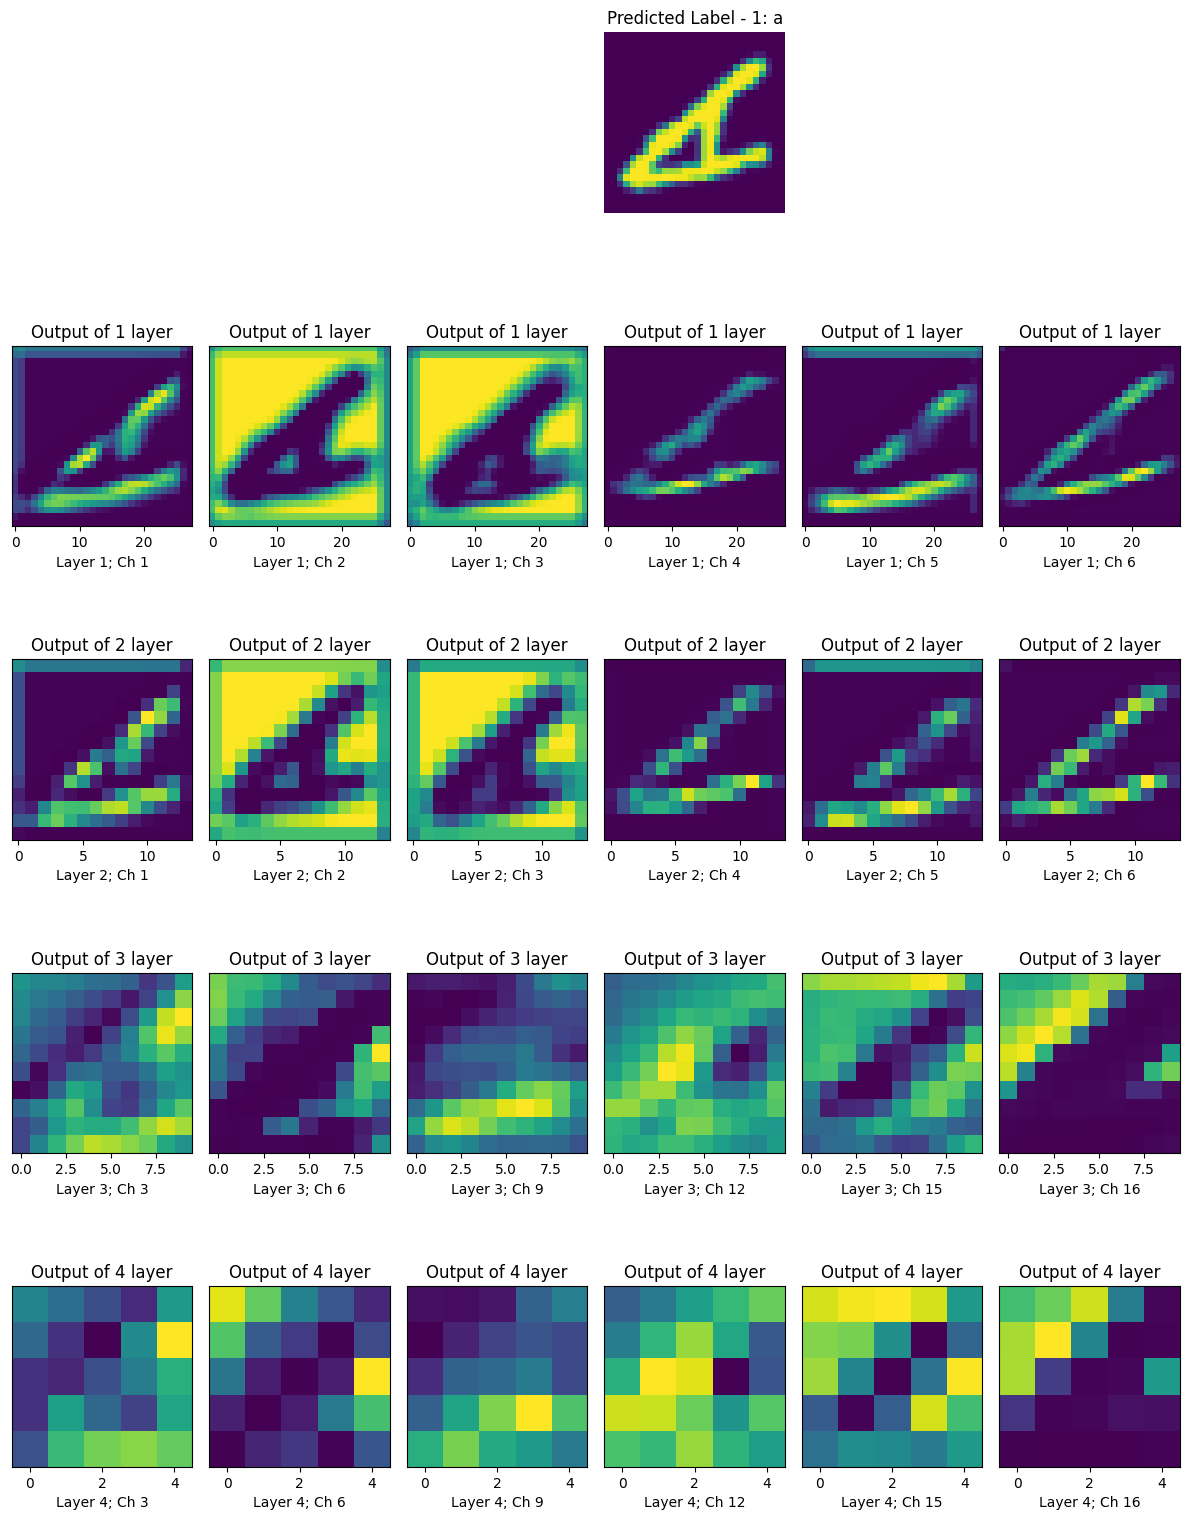

In [42]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[1]
predicted_label, layers_output = lenet_nap.predict(example_image)
visualize(data.class_names, example_image, predicted_label, layers_output, number_of_plots_in_row = 6)

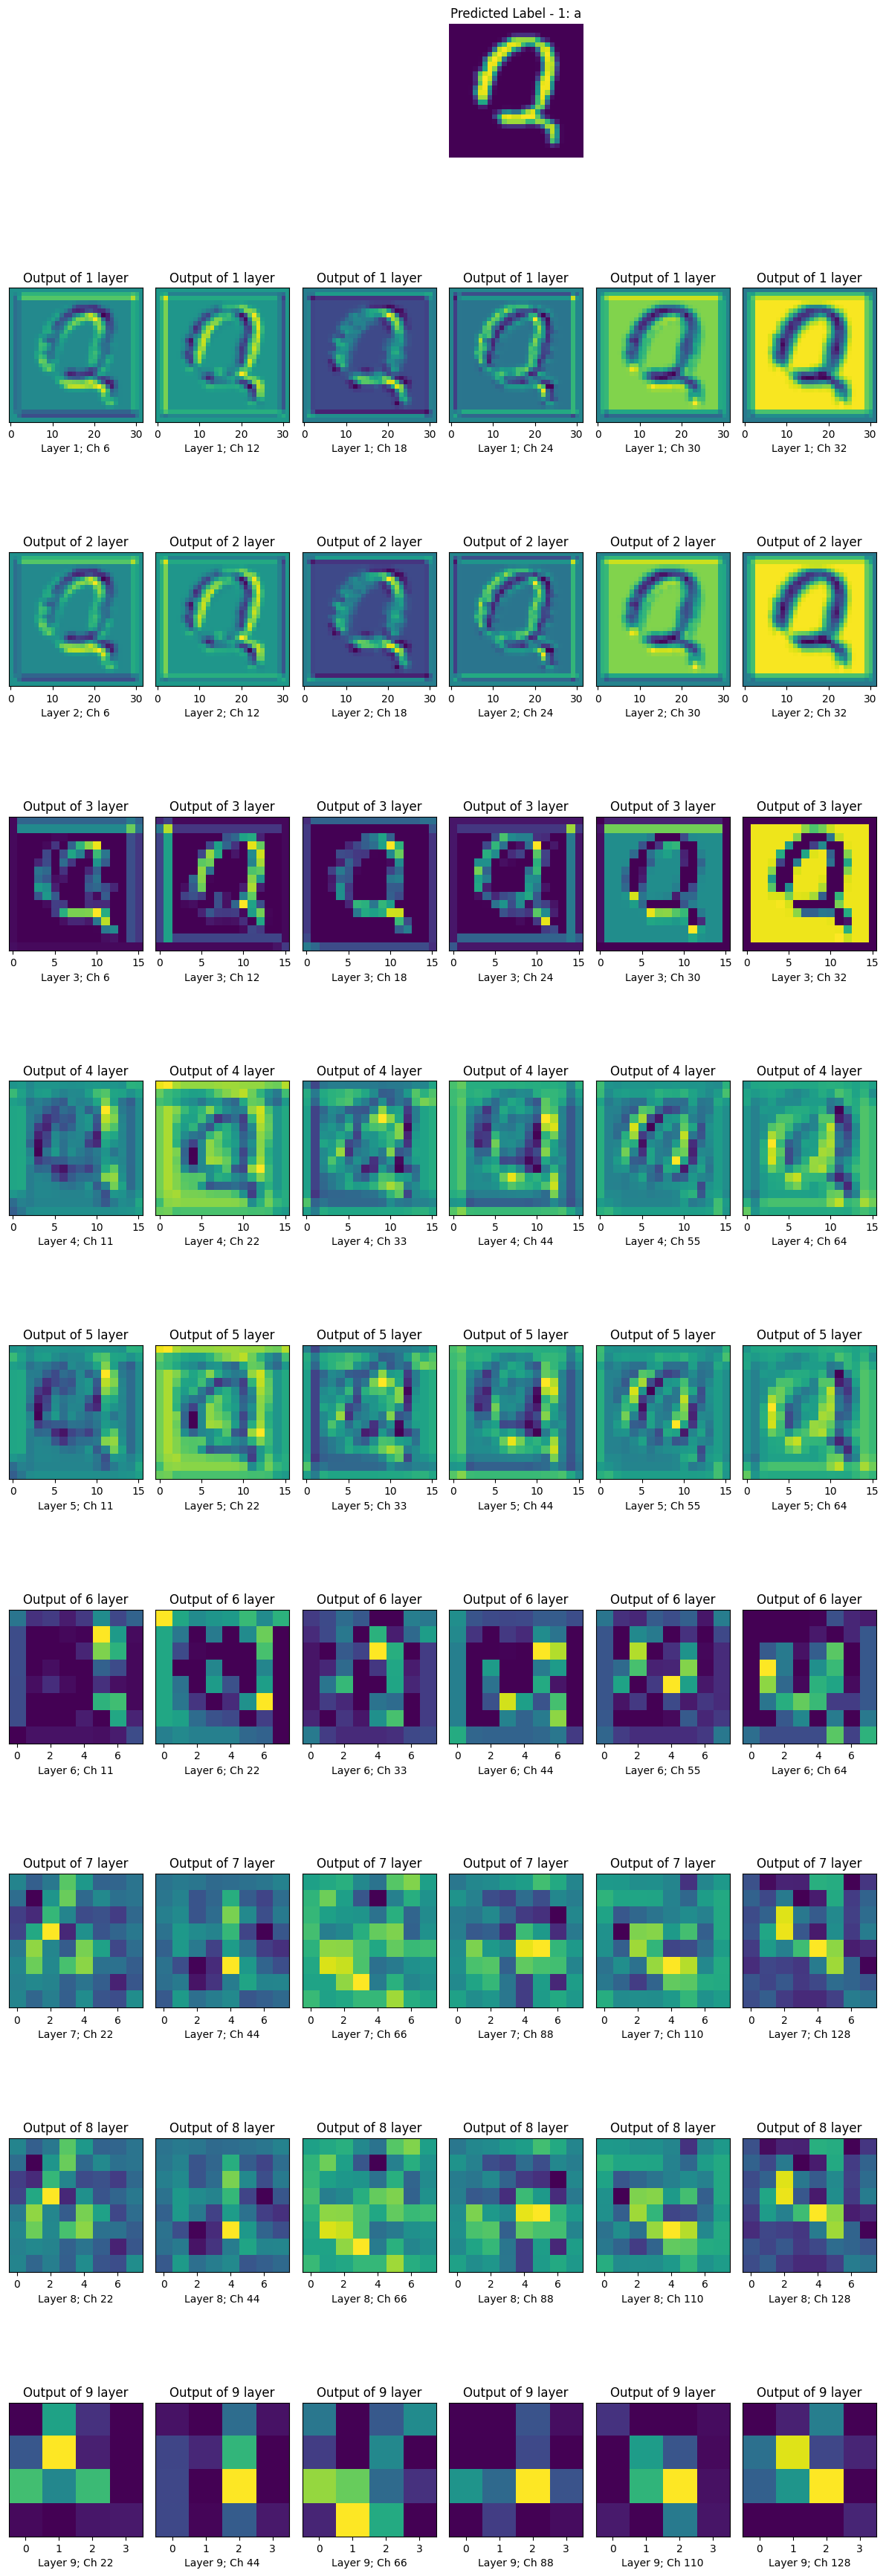

In [43]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[2]
predicted_label, layers_output = lenet_b.predict(example_image)
visualize(data.class_names, example_image, predicted_label, layers_output, number_of_plots_in_row = 6)